In [1]:
# %matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from modules import utility as uty
import os
import pickle as pkl
import h5py
import copy
import time
from tqdm import tqdm
import itertools
import functools
from skimage.metrics import structural_similarity
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from modules import utility as uty
from scipy.ndimage.filters import gaussian_filter

In [2]:
uty.handle_GPUs(GPUs = '4, 5', enable_GPU=1,)

number of Logical GPUs: 2


2024-09-16 17:48:12.788505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyper-Parameters

In [3]:
R_list = [
    3.0, 3.25, 3.5, 3.75,
    4.0, 4.25, 4.5, 4.75,
    5.0, 5.25, 5.5, 5.75,
    6.0, 6.5,
    7.0,
    8.0,
    9.0,
    10.0,
    12.0,
    16.0,
    20.0,
    24.0,
    32.0,
    64.0,
]

use_case = 'IXI-Cartesian'

print('len(R_list) = ', len(R_list))

R_masker_list = [0.0, ] + R_list[:-1]
R_masker_of_the_masker_list = [0.0 ] + R_masker_list[:-1]


all_versions_sa = [1]

dec = 2
L = 0
# directory = 'LOUPE-decremental'
directory = 'LOUPE-decremental-IXI-sense_columns'

max_model_ID = 1

volume_for_bias_estimation = 0

verbose = True

len(R_list) =  24


2024-09-16 17:48:15.738513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76361 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-16 17:48:15.758071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 25321 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


# Find the best models (MASKER)

In [4]:
### FIND THE BEST MASKER ###

additional_id_string_list = []

verbose = False

if verbose == True:
    fig, axs = plt.subplots(len(R_list), 3)

    fig.set_figheight(len(R_list)*5)
    fig.set_figwidth(15)

for i, (R, R_masker) in enumerate(zip(R_list, R_masker_list)):
    
    PSNR = 0
    additional_id_string = None
    PSNR_tmp_list = []
    mask_list_tmp = []
    
    for additional_id_string_tmp in range(max_model_ID+1):
        
        kwargs_model_tmp = {
            'R': R,
            'R_masker': R_masker,
        }

        if directory is not(None):
            kwargs_model_tmp['directory'] = directory
        if additional_id_string_tmp is not None:
            kwargs_model_tmp['ID'] = additional_id_string_tmp

        path_model_tmp, _ = uty.from_id_to_model_path(**kwargs_model_tmp)

        with open(os.path.join(path_model_tmp, 'model_evaluate.pkl'), 'rb') as f:
            PSNR_tmp = pkl.load(f)
            PSNR_tmp_list += [PSNR_tmp]
        
        
        path_model_mask_tmp = os.path.join(
            path_model_tmp,
            'mask',
            'mask.pkl',
        )
        with open(path_model_mask_tmp, 'rb') as f:
            mask_list_tmp += [pkl.load(f)]
        
        
        if PSNR_tmp > PSNR:
            PSNR = PSNR_tmp
            additional_id_string = additional_id_string_tmp

    if verbose == True:
        print('R = ',R,' - Best masker ID: ',additional_id_string,
              '\nBest PSNR = ', PSNR,
              ' - Mean / std PSNR = ', np.mean(PSNR_tmp_list),'/',np.std(PSNR_tmp_list),'\n',
              'all PSNR : ',PSNR_tmp_list,'\n',
             )
        
        uty._rotate_corners_mask(mask_list_tmp[additional_id_string], plot = True, ax = axs[i,0])
        uty._rotate_corners_mask(np.mean(mask_list_tmp, 0), plot = True, ax = axs[i,1])
        
        xor_masks = np.mean([m ^ mask_list_tmp[additional_id_string] for m in mask_list_tmp], 0)
        xor_masks = np.mean([np.mean([m ^ m_ref for m in mask_list_tmp], 0) for m_ref in mask_list_tmp], 0)
        
        
        uty._rotate_corners_mask(xor_masks, plot = True, ax = axs[i,2])
        axs[i, 0].title.set_text('R = '+str(R)+'\nmask model highest PSNR')
        axs[i, 1].title.set_text('masks mean')
        axs[i, 2].title.set_text('mean of xorred masks')
        
    
    additional_id_string_list += [additional_id_string]

In [5]:
def extract_mask():
    mask_list = []
    
    for i, (R, R_masker, additional_id_string) in enumerate(zip(R_list, R_masker_list, additional_id_string_list)):
        kwargs_model = {
            'R': R,
            'R_masker': R_masker,
        }

        if directory is not(None):
            kwargs_model['directory'] = directory
        if additional_id_string is not None:
            kwargs_model['ID'] = additional_id_string

        path_model, _ = uty.from_id_to_model_path(**kwargs_model)

        ### MASK ###

        path_mask = os.path.join(path_model, 'mask', 'mask.pkl')
        with open(path_mask, 'rb') as f:
            mask_list += [pkl.load(f)]
    return mask_list

In [6]:
mask_list = extract_mask()

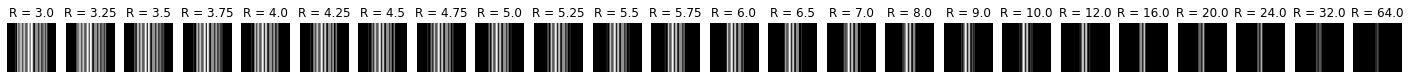

In [7]:
n = len(mask_list)

fig, axs = plt.subplots(1, n, squeeze = False)
fig.set_figheight(10)
fig.set_figwidth(25)
for m, ax, R in zip(mask_list, axs[0], R_list):
    
    uty._rotate_corners_mask(m, plot = True, ax = ax)
    ax.title.set_text('R = '+str(R))

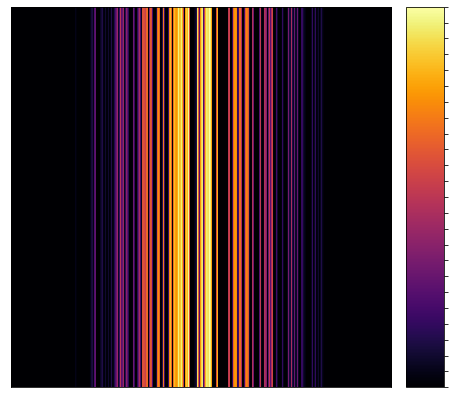

In [8]:
mask_list_rot = [uty._rotate_corners_mask(m) for m in mask_list]

priority_chart = np.sum(mask_list_rot, (0, 3))/len(mask_list_rot)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(7)
im = ax.imshow(priority_chart, cmap = 'inferno')
ax.set(yticks = [], xticks = [])

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.2)
cax.set(yticks=[], yticklabels=[])
# cax.set_ticks([])
# ax.set(title = 'PRIORITY CHART -- '+directory, )
cbar = plt.colorbar(im, cax=cax, )
ticks = np.append(np.arange(0, 1 , 1/(len(R_list))), 1.0)
ticks_labels = np.append([1.0], R_list)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks_labels)
cbar.set_ticklabels([])
plt.savefig(os.path.join('results_paper', f'priority_chart_{directory}.pdf'),bbox_inches='tight', pad_inches = 0)

plt.show();

In [9]:
data_for_csv = pd.DataFrame(priority_chart);
data_for_csv.index.name = 'index'
data_for_csv.columns.name = 'columns'


In [10]:
# plot_list = [mse_pred, mae_pred, R_to_visualize]
# index_list = ['MSE', 'MAE', 'R_plot']

f_name = f'quality_estimator_performance_{use_case}'

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

NameError: name 'plot_list' is not defined

In [11]:
priority_chart


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
start = 0.226
end = -5.045
num = np.arange(len(R_list))+1
# print(start - np.abs((end-start)/len(R_list)*(num-1)))
[(np.round(start - np.abs((end-start)/len(R_list)*(i-1)), 4), R_list[-i]) for i in num]

[(0.226, 64.0),
 (0.0064, 32.0),
 (-0.2132, 24.0),
 (-0.4329, 20.0),
 (-0.6525, 16.0),
 (-0.8721, 12.0),
 (-1.0918, 10.0),
 (-1.3114, 9.0),
 (-1.531, 8.0),
 (-1.7506, 7.0),
 (-1.9702, 6.5),
 (-2.1899, 6.0),
 (-2.4095, 5.75),
 (-2.6291, 5.5),
 (-2.8488, 5.25),
 (-3.0684, 5.0),
 (-3.288, 4.75),
 (-3.5076, 4.5),
 (-3.7272, 4.25),
 (-3.9469, 4.0),
 (-4.1665, 3.75),
 (-4.3861, 3.5),
 (-4.6057, 3.25),
 (-4.8254, 3.0)]

In [13]:
start = 0.226
end = -5.045
start + (end-start)/2

-2.4095

## Reconstruction visualization

In [14]:
subset_R = [3.0, 12.0, 64.0]

conditions = [np.array(R_list) == i for i in subset_R]
conditions = functools.reduce(np.logical_or, conditions)
subset_ind_R = np.where(conditions)

trecon_dict = {}
for R in subset_R:
    trecon_dict[R]=[]

mask_dict = {}
for R in subset_R:
    mask_dict[R]=[]

for R, R_masker, additional_id_string in tqdm(
    zip(np.array(R_list)[subset_ind_R], np.array(R_masker_list)[subset_ind_R], np.array(additional_id_string_list)[subset_ind_R])):
    kwargs_model = {
        'R': R,
        'R_masker': R_masker,
    }

    if directory is not(None):
        kwargs_model['directory'] = directory
    if additional_id_string is not None:
        kwargs_model['ID'] = additional_id_string

    path_model, _ = uty.from_id_to_model_path(**kwargs_model)
        
    ###### MASKS ######

    path_mask = os.path.join(path_model, 'mask', 'mask.pkl')
    with open(path_mask, 'rb') as f:
        mask_dict[R] = pkl.load(f)
    
    ### SCORES ###
    
    path_self_assessment_h5 = os.path.join(path_model, 'self-assessment', 'dataset.h5')
    
    with h5py.File(path_self_assessment_h5, "r") as f:

        ###### IMAGES ######

        d_reconstruction = f['reconstructed_image']

        trecon_dict[R] = np.array(d_reconstruction['test'])[..., 0]

3it [00:09,  3.16s/it]


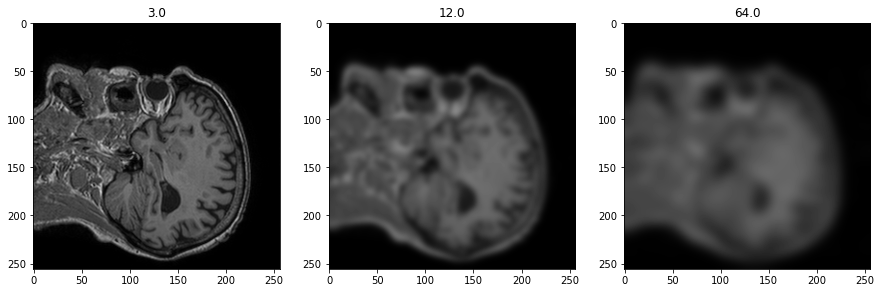

In [15]:
ind_tmp = 50
fig, axs = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(15)

sigma_list = [0.0, 3, 6]

[(
    ax.imshow(gaussian_filter(i, sigma=s), cmap = 'gray', vmin = 0, vmax = 1),
    ax.title.set_text(j)
 ) for ax, (i, j), s in zip(axs, [(trecon_dict[j][ind_tmp], j) for j in subset_R], sigma_list)];

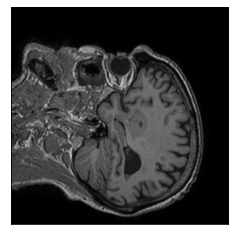

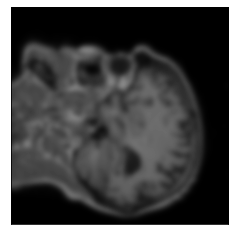

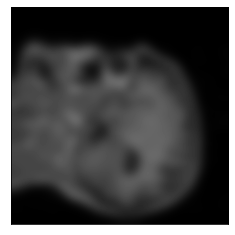

In [16]:
ind_tmp = 50

sigma_list = [0., 3, 6]

[(
    plt.imshow(gaussian_filter(i, sigma=s), cmap = 'gray', vmin = 0, vmax = 1),
    plt.yticks([]),
    plt.xticks([]),
    plt.savefig(os.path.join('results_paper', f'recon_slice-ind_{ind_tmp}-R_{j}-{use_case}.png'),bbox_inches='tight', pad_inches = 0),
    plt.show()
 ) for (i, j), s in zip([(trecon_dict[j][ind_tmp], j) for j in subset_R], sigma_list)];

## Masks

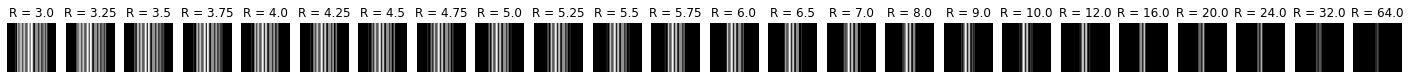

In [17]:
n = len(mask_list)

fig, axs = plt.subplots(1, n, squeeze = False)
fig.set_figheight(10)
fig.set_figwidth(25)
for m, ax, R in zip(mask_list, axs[0], R_list):
    
    uty._rotate_corners_mask(m, plot = True, ax = ax)
    ax.title.set_text('R = '+str(R))

In [18]:
mask_diff_dict = {}

k = list(mask_dict.keys())
k2 = list(k)[1:]
for i, j in zip(k, k2):
    mask_diff_dict[i] = mask_dict[i] ^ mask_dict[j]
    
mask_diff_dict[k[-1]] = mask_dict[k[-1]]

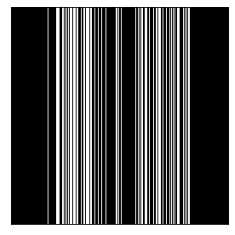

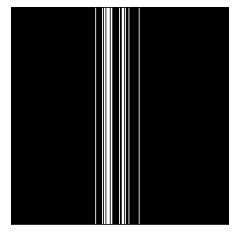

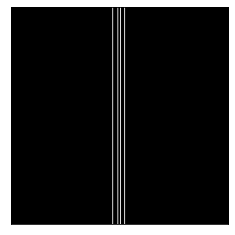

In [19]:
[(
    plt.imshow(uty._rotate_corners_mask(i), cmap = 'gray', vmin = 0, vmax = 1),
    plt.yticks([]),
    plt.xticks([]),
    plt.savefig(os.path.join('results_paper', f'mask-R_{j}-{use_case}.png'),bbox_inches='tight', pad_inches = 0),
    plt.show()
 ) for i, j in [(mask_diff_dict[j], j) for j in subset_R]];

## k-space visualization

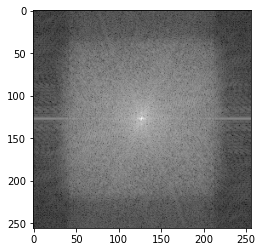

In [20]:
trecon_tmp = np.abs(np.fft.fft2(trecon_dict[3.0][ind_tmp]))
trecon_tmp = (trecon_tmp-np.min(trecon_tmp))/(np.max(trecon_tmp)-np.min(trecon_tmp))+10**(-6)
trecon_tmp = np.log10(trecon_tmp)
trecon_tmp = uty._rotate_corners_mask(trecon_tmp)

trecon_tmp = (trecon_tmp-np.min(trecon_tmp))/(np.max(trecon_tmp)-np.min(trecon_tmp))+10**(-6)

plt.imshow(trecon_tmp, cmap = 'gray');

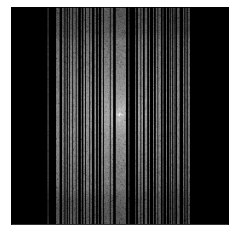

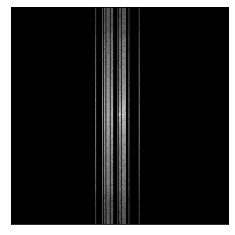

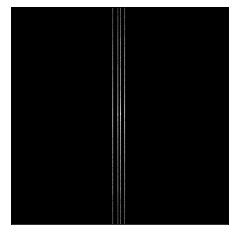

In [21]:
[(
    plt.imshow(trecon_tmp*uty._rotate_corners_mask(i)[..., 0], cmap = 'gray'),
    plt.yticks([]),
    plt.xticks([]),
    plt.savefig(os.path.join('results_paper', f'k_space-ind_{ind_tmp}-R_{j}-{use_case}.png'),bbox_inches='tight', pad_inches = 0),
    plt.show()
 ) for i, j in [(mask_dict[j], j) for j in subset_R]];

# Extract the data

In [22]:
def extract_data(volume_for_bias_estimation, extract_image = False):

    ascore_dict = {}
    tscore_dict = {}
    vscore_dict = {}
    xscore_dict = {}
    
    timage_dict = {}
    
    gamma_sa_list = []

    def to_PSNR(metric, data_type = 'MSE', eps = 10e-8):

        if data_type == 'MSE' or data_type == 'MAE':
            metric = 10 * np.log10(1/(metric+eps))
            if data_type == 'MAE':
                metric = metric * 2

            metric[np.argwhere(np.isnan(metric))] = 70
                
        return metric



    for i, (R, R_masker, additional_id_string) in enumerate(zip(R_list, R_masker_list, additional_id_string_list)):
        kwargs_model = {
            'R': R,
            'R_masker': R_masker,
        }

        if directory is not(None):
            kwargs_model['directory'] = directory
        if additional_id_string is not None:
            kwargs_model['ID'] = additional_id_string

        path_model, _ = uty.from_id_to_model_path(**kwargs_model)


        ### SCORES ###

        path_self_assessment_h5 = os.path.join(path_model, 'self-assessment', 'dataset.h5')

        with h5py.File(path_self_assessment_h5, "r") as f:
            
            d_reconstruction = f['reconstructed_image']

            d_hfen_ssim = f['hfen_ssim-R_'+str(R)]

            l = len(np.array(d_hfen_ssim['HFEN_true_test']))
            condition_t = np.ones(l, dtype = bool)
            
            if volume_for_bias_estimation is not None:
                condition_t[150*volume_for_bias_estimation: 150*(volume_for_bias_estimation+1)] = 0
            else:
                None
            
            condition_a = [not(c) for c in condition_t]
            
            id_image_tmp = R
            
            if extract_image == True:
                timage_dict[R] = np.array(d_reconstruction['test'])[condition_t]
                        
            # timage_dict[R] = np.extract(condition_t, d_reconstruction['test'])
            # timage_dict[R] = np.extract(condition_t, d_reconstruction['test'])

            for data_id_tmp in ['HFEN_true', 'SSIM_true']:

                if i == 0:

                    ascore_dict[data_id_tmp] = {}
                    tscore_dict[data_id_tmp] = {}
                    vscore_dict[data_id_tmp] = {}
                    xscore_dict[data_id_tmp] = {}

                ascore_dict[data_id_tmp][R] = np.extract(condition_a, np.array(d_hfen_ssim[data_id_tmp+'_test']))
                tscore_dict[data_id_tmp][R] = np.extract(condition_t, np.array(d_hfen_ssim[data_id_tmp+'_test']))
                vscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_val'])
                xscore_dict[data_id_tmp][R] = np.array(d_hfen_ssim[data_id_tmp+'_train'])

            for metric_type, data_type in itertools.product(['MAE', 'MSE'], ['_pred', '_true']):

                for version_sa in all_versions_sa:

                    if version_sa == 1:
                        additional_string_tmp = ''
                        key_group_list = [(metric_type+additional_string_tmp, '')]
                    else:
                        additional_string_tmp = '_v'+str(version_sa)
                        key_group_ref = metric_type+additional_string_tmp
                        key_group_list = [(k, k.replace(key_group_ref, '')) 
                                          for k in f.keys() 
                                          if key_group_ref in k
                                         ]

                    for key_group, gamma_sa_string in key_group_list:

                        try:
                            d = f[key_group]

                            if data_type == '_pred':
                                d_tmp = d['predictions_score']
                                modify_dimension = lambda x: x[...,0]

                            elif data_type == '_true':
                                d_tmp = d['true_score']
                                modify_dimension = lambda x: x

                            if gamma_sa_string != '':

                                gamma_sa_tmp = float(gamma_sa_string[gamma_sa_string.find('_g')+2:])
                                string_to_save = key_group_ref+'_'+str(gamma_sa_tmp)

                                try:
                                    if not (string_to_save in gamma_sa_list):
                                        gamma_sa_list += [string_to_save]
                                    else:
                                        None
                                except:
                                    gamma_sa_list = [string_to_save]
                                pass

                            id_dataset = metric_type+data_type+additional_string_tmp+gamma_sa_string


                            if i == 0:

                                ascore_dict[id_dataset] = {}
                                tscore_dict[id_dataset] = {}
                                vscore_dict[id_dataset] = {}
                                xscore_dict[id_dataset] = {}


                            # ascore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.extract(condition_a, np.array(d_tmp['test']))), metric_type)
                            ascore_dict[id_dataset][R] = to_PSNR(np.extract(condition_a, np.array(d_tmp['test'])), metric_type)

                            # tscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.extract(condition_t, np.array(d_tmp['test']))), metric_type)
                            tscore_dict[id_dataset][R] = to_PSNR(np.extract(condition_t, np.array(d_tmp['test'])), metric_type)

                            vscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['val'])), metric_type)

                            xscore_dict[id_dataset][R] = to_PSNR(modify_dimension(np.array(d_tmp['train'])), metric_type)



                        except:
                            print(R, 'has not associated data')

        pass
    
    if extract_image == True:
        return  ascore_dict, tscore_dict, vscore_dict, xscore_dict, timage_dict
    else:
        return  ascore_dict, tscore_dict, vscore_dict, xscore_dict

## Score TRUE - PREDICTED comparison

Compare TRUE vs PREDICTED quality

## BIAS ESTIMATOR

In [23]:
class My_Poly():
    
    def __init__(self, deg = 2):
        self.deg = deg
        
        
    def modify_shape(self, X):
        if np.shape(X)[-1] == 1:
            return X[..., 0]
        else:
            return X
    
    def my_fit(self, X, y):
        X = self.modify_shape(X)
        y = self.modify_shape(y)
        p = np.polyfit(X, y, self.deg)
        self.p = p
        self.compute_pearson(X, y)
        
        return p
    
    def my_predict(self, X):
        X = self.modify_shape(X)
        y = np.polyval(self.p, X)
        return y
    
    def compute_pearson(self, X, y):
        
        X = self.modify_shape(X)
        y = self.modify_shape(y)
        
        pred = self.my_predict(X)
        
        pearson = np.corrcoef(y, pred)[0][1]
        
        self.pearson = pearson
        
        return pearson
    
class My_TheilSenRegressor(TheilSenRegressor):
    
    def modify_shape(self, X):
        if np.shape(X)[-1] != 1:
            return X[..., np.newaxis]
        else:
            return X
    
    def my_fit(self, X, y):
        
        X = self.modify_shape(X)
        # y = self.modify_shape(y)
        
        super(My_TheilSenRegressor, self).fit(X, y)
        
        p = list(self.coef_) + [self.intercept_]
                
        self.p = p
        self.compute_pearson(X, y)
        
        return
        
    def my_predict(self, X):
        
        X = self.modify_shape(X)
        
        pred = super(My_TheilSenRegressor, self).predict(X)

        return pred
        
    def compute_pearson(self, X, y):
        
        X = self.modify_shape(X)
        # y = self.modify_shape(y)
        
        pred = self.my_predict(X)
                
        pearson = np.corrcoef(y, pred)[0][1]
        
        self.pearson = pearson
        
        return pearson

In [24]:
def bias_correction(estimator, estimator_name, ascore_dict, tscore_dict, threshold_pearson = 0.5, verbose = False):
    
    result_dict = {}
    
    for i, R_tmp in enumerate(R_list):

        X = ascore_dict['MAE_pred'][R_tmp]
        y = ascore_dict['MAE_true'][R_tmp] - ascore_dict['MAE_pred'][R_tmp]

        X[np.argwhere(np.isnan(X))] = 70

        estimator.my_fit(X, y)
        
        pearson = estimator.pearson

        key = 'MAE_pred_bias_'+estimator_name
        
        if i == 0:
            result_dict[key] = {}
        
        result_dict[key][R_tmp] = {}
        
        if pearson > threshold_pearson:
            result_dict[key][R_tmp]['values'] = tscore_dict['MAE_pred'][R_tmp] + estimator.my_predict(tscore_dict['MAE_pred'][R_tmp])
        else:
            result_dict[key][R_tmp]['values'] = tscore_dict['MAE_pred'][R_tmp]
        
        result_dict[key][R_tmp]['error'] = np.mean((result_dict[key][R_tmp]['values'] - tscore_dict['MAE_true'][R_tmp])**2)
        
    return result_dict

In [25]:
estimators = {
    # "Poly_1": My_Poly(1),
    "Poly_2": My_Poly(2),
    # "Poly_3": My_Poly(3),
    "Theil-Sen": My_TheilSenRegressor(),
}

threshold_pearson = 0.2

tscore_bias_dict = {}

for j, (estimator_name, estimator) in enumerate(estimators.items()):
    
    for k_fold_tmp in range(8):
        
        if j == 0:
            tscore_bias_dict['k_fold_'+str(k_fold_tmp)] = {}
        
        ascore_dict_tmp, tscore_dict_tmp, _, _ =  extract_data(k_fold_tmp)

        result_dict_tmp = bias_correction(
                estimator,
                estimator_name,
                ascore_dict_tmp,
                tscore_dict_tmp,
                threshold_pearson,
                verbose = False,
            )
        
        tscore_bias_dict['k_fold_'+str(k_fold_tmp)].update(result_dict_tmp)

/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))
/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid valu

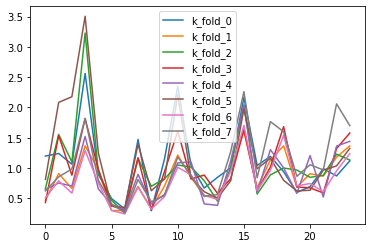

In [26]:
estimator_name = 'Poly_2'

for k, v in tscore_bias_dict.items():
    
    key = 'MAE_pred_bias_'+estimator_name
    
    v_tmp = v[key]
    
    plt.plot([r['error'] for R_tmp, r in v_tmp.items()], label = k)
    
plt.legend();

In [27]:
k_fold = np.random.randint(0, 8)
k_fold = 1
metric_type = 'MAE'
estimator_name = 'Poly_2'

# _, tscore_dict, vscore_dict, xscore_dict =  extract_data(k_fold, extract_image = False)
_, tscore_dict, vscore_dict, xscore_dict, timage_dict =  extract_data(k_fold, extract_image = True)

print('random k_fold =', k_fold)

/tmp/ipykernel_1601533/1746685211.py:15: RuntimeWarning: invalid value encountered in log10
  metric = 10 * np.log10(1/(metric+eps))


random k_fold = 1


In [28]:
np.shape(timage_dict[3.0])

(1050, 256, 256, 1)

In [29]:
for i, R_tmp in enumerate(R_list):
    
    bias_corrected = tscore_bias_dict['k_fold_'+str(k_fold)][metric_type+'_pred_bias_'+estimator_name][R_tmp]['values']
    
    tscore_dict['MAE_pred'][R_tmp] = bias_corrected
    # d_reconstruction

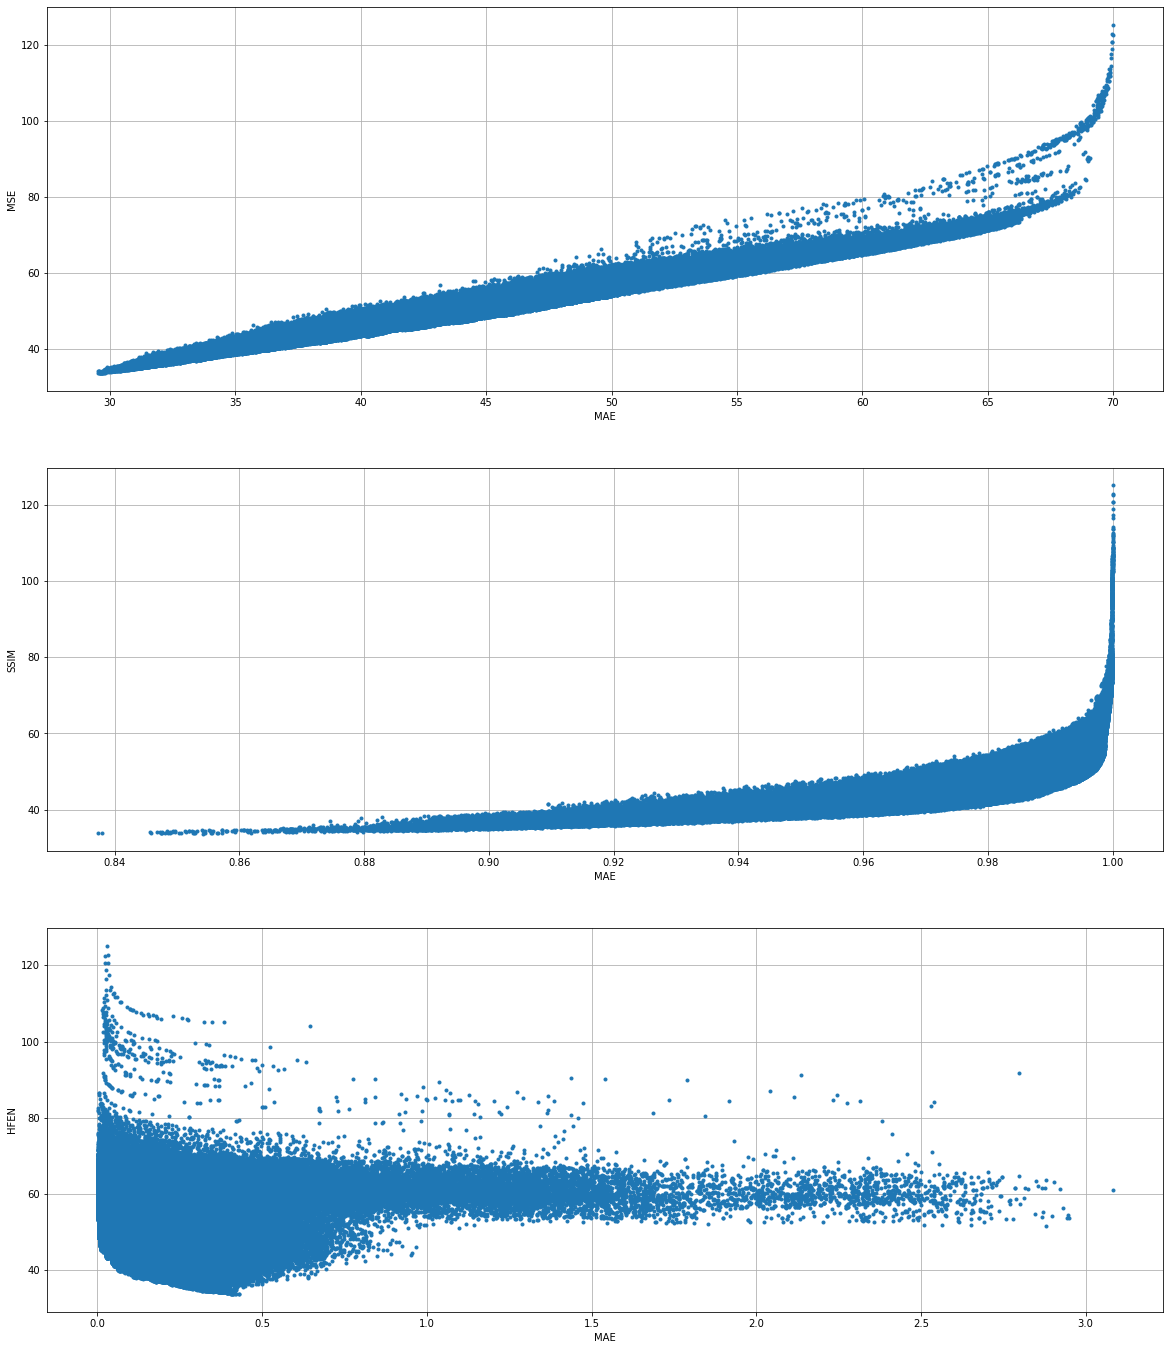

In [30]:
metric_type = ['MSE', 'MAE']

fig, axs = plt.subplots(3, 1)
fig.set_figheight(8*3)
fig.set_figwidth(20)


mae_true = np.array(list(xscore_dict['MAE_true'].values())).ravel()

mse_true = np.array(list(xscore_dict['MSE_true'].values())).ravel()

hfen_true = np.array(list(xscore_dict['HFEN_true'].values())).ravel()

ssim_true = np.array(list(xscore_dict['SSIM_true'].values())).ravel()


axs[0].plot(mse_true,mae_true,'.')
axs[1].plot(ssim_true,mae_true,'.')
axs[2].plot(hfen_true,mae_true,'.')

axs[0].set_ylabel('MSE')
axs[1].set_ylabel('SSIM')
axs[2].set_ylabel('HFEN')

for ax in axs:
    ax.grid('on')
    ax.set_xlabel('MAE')

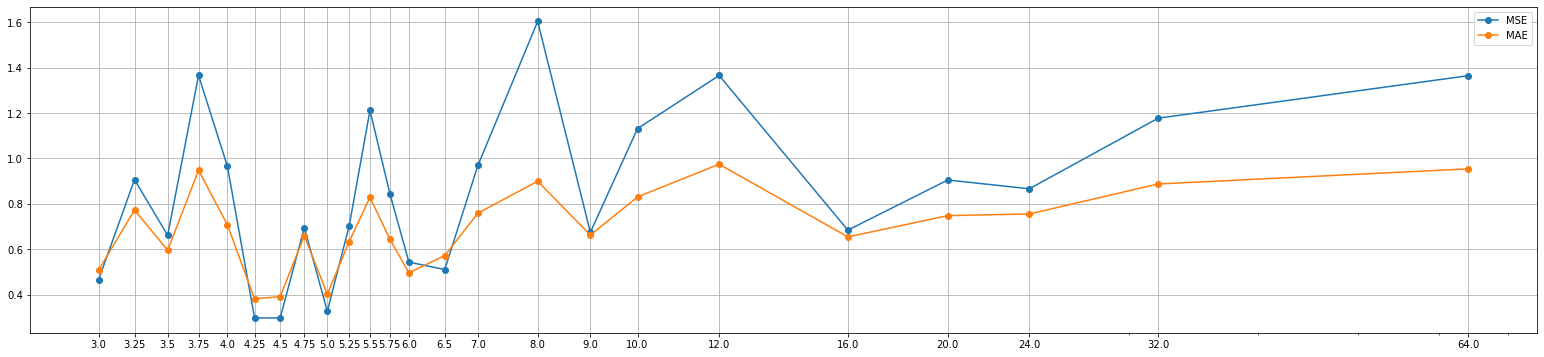

In [31]:
R_to_visualize = R_list

metric_type = 'MAE'

mse_pred = [np.mean((tscore_dict[metric_type+'_true'][R_tmp]-tscore_dict[metric_type+'_pred'][R_tmp])**2) for R_tmp in R_to_visualize]
mae_pred = [np.mean(np.abs(tscore_dict[metric_type+'_true'][R_tmp]-tscore_dict[metric_type+'_pred'][R_tmp])) for R_tmp in R_to_visualize]

# print(mse_pred)

fig, axs = plt.subplots(1, 1, squeeze = True)
fig.set_figheight(6)
fig.set_figwidth(27)

axs.plot(R_to_visualize, mse_pred, '-o', label = 'MSE');
axs.plot(R_to_visualize, mae_pred, '-o', label = 'MAE');

axs.set_xscale('log')
axs.set_xticks(R_to_visualize)
axs.set_xticklabels(R_to_visualize)
axs.legend()
axs.grid('on');

plot_list = [mse_pred, mae_pred, R_to_visualize]
index_list = ['MSE', 'MAE', 'R_plot']

f_name = f'quality_estimator_performance_{use_case}'

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [32]:
# R_list_to_delete = [3.25, 3.75, 4.0, 5.5, 7.0, 8.0, 10.0, 12.0, 20.0, 24.0, 32.0, 64.0]

# score_dict_list = [tscore_dict, vscore_dict, xscore_dict]
# for score_dict in score_dict_list:
#     for k in score_dict.keys():
#         for R_tmp in R_list_to_delete:
#             score_dict[k].pop(R_tmp)
            

# for R_tmp in R_list_to_delete:
#     R_list.remove(R_tmp)

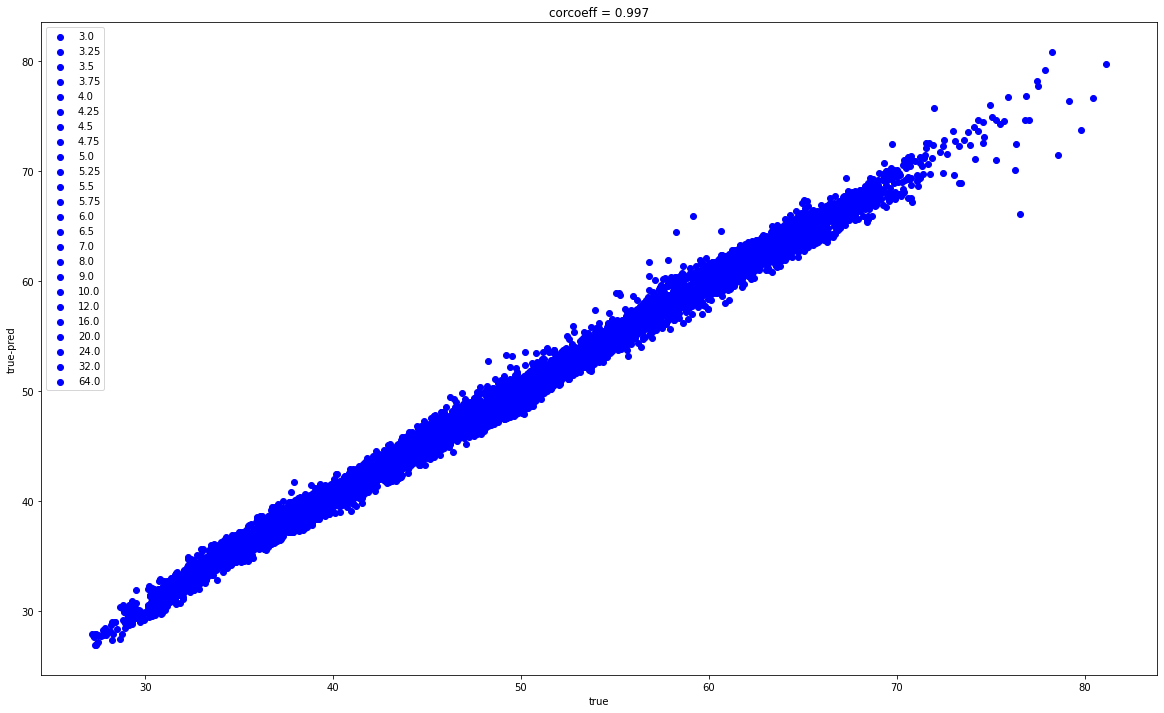

In [33]:
metric_type = ['MAE']

plot_list = []
index_list = []

R_to_visualize = [4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 16.0,]
R_to_visualize = R_list

fig, axs = plt.subplots(len(metric_type), 1, squeeze = False)
axs = axs[0]
fig.set_figheight(12)
fig.set_figwidth(20)
for ax, m in zip(axs, metric_type):
    
    score_true = [
            ax.scatter(tscore_dict[m+'_true'][R_tmp][-450:], tscore_dict[m+'_pred'][R_tmp][-450:], c = 'blue', label = R_tmp) 
            for R_tmp
            in R_to_visualize
        ]
    
    plot_list += [np.array([
            tscore_dict[m+'_true'][R_tmp][-450:]
            for R_tmp
            in R_to_visualize
        ]).reshape(-1)]
    
    index_list += ['MAE_true']
    
    plot_list += [np.array([
            tscore_dict[m+'_pred'][R_tmp][-450:]
            for R_tmp
            in R_to_visualize
        ]).reshape(-1)]
    
    index_list += ['MAE_pred']
    
    corrcoef = np.corrcoef(
            np.array([i for i in tscore_dict[m+'_true'].values()]).reshape(-1),
            np.array([i for i in tscore_dict[m+'_pred'].values()]).reshape(-1),
        )
    
    ax.title.set_text(f'corcoeff = {np.round(corrcoef[0][1], 3)}')
    ax.set_xlabel('true')
    ax.set_ylabel('true-pred');
    ax.legend()
    
f_name = f'MAE_pred_vs_true_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

### Corcoeff for different R

In [34]:
metric_type = ['MAE']

R_to_visualize = [4.0, 6.0, 10.0, 16.0]

print('\t\t', use_case)

for m in metric_type:
    
    for R_tmp in R_to_visualize:
        
        true_tmp, pred_tmp = tscore_dict[m+'_true'][R_tmp], tscore_dict[m+'_pred'][R_tmp]
        
        corrcoef = np.corrcoef(
                true_tmp, pred_tmp
            )
    
        print(f'{R_tmp}) corcoeff = {np.round(corrcoef[0][1], 3)}')

		 IXI-Cartesian
4.0) corcoeff = 0.995
6.0) corcoeff = 0.997
10.0) corcoeff = 0.996
16.0) corcoeff = 0.997


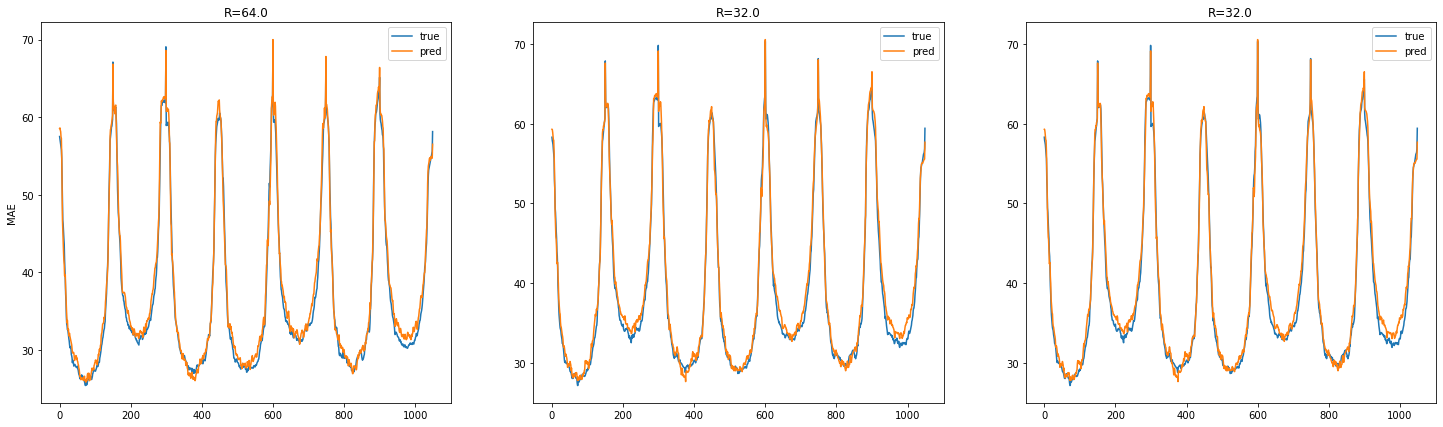

In [35]:
# R_to_visualize = np.sort(np.unique(np.array(R_list)[np.random.randint(0, len(R_list), 4)]))
R_to_visualize = np.array(R_list)[np.random.randint(0, len(R_list), size = (3, ))]
# R_to_visualize = R_list

metric_type_list = ['MAE']

fig, axs = plt.subplots(len(metric_type_list), len(R_to_visualize), sharey = False, squeeze = False)
fig.set_figheight(7*len(metric_type_list))
fig.set_figwidth(25)
        

for axx, metric_type in zip(
        axs,
        metric_type_list,
    ):
    for ax, R_tmp in zip(axx, R_to_visualize):
        
        g_tmp_str = ''
        ax.plot(tscore_dict[metric_type+'_true'][R_tmp],'')
        ax.plot(tscore_dict[metric_type+'_pred'][R_tmp],'')
        
        ax.legend(['true','pred'])
        ax.title.set_text('R='+str(R_tmp))

    axx[0].set_ylabel(metric_type)
    
plot_list = []
index_list = []

for metric_type in metric_type_list:
    for R_tmp in R_list:
        plot_list += [tscore_dict[metric_type+'_true'][R_tmp][-450:]]
        index_list += ['true_'+str(R_tmp)]
        
        plot_list += [tscore_dict[metric_type+'_pred'][R_tmp][-450:]]
        index_list += ['pred_'+str(R_tmp)]
    
    
f_name = f'volume_quality_pred_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

# data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

## Visualization PSNR

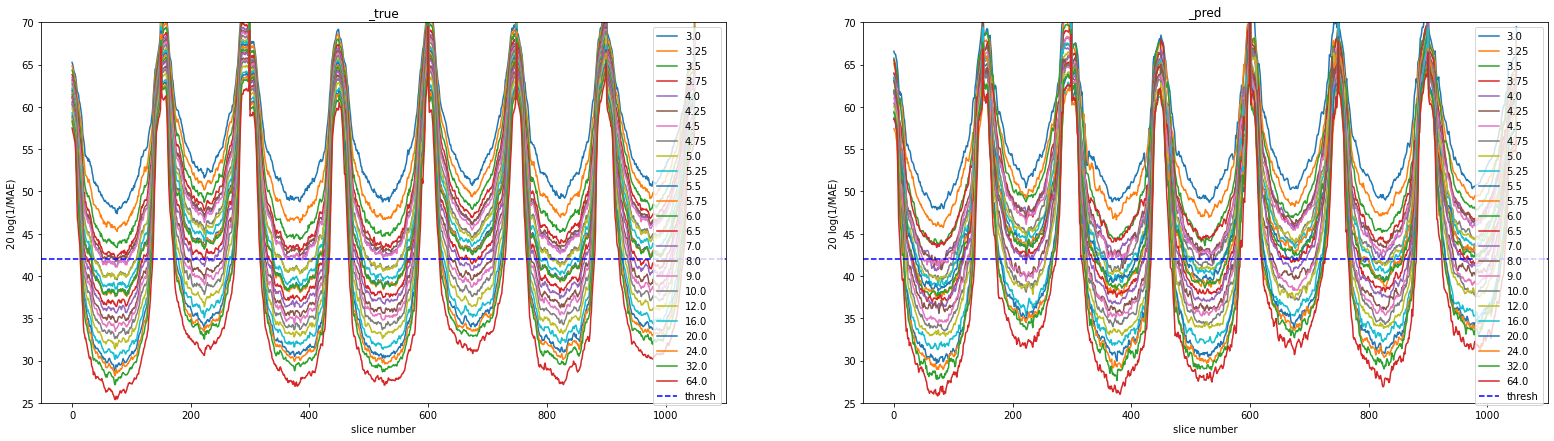

In [36]:
threshold_PSNR = 42 # PSNR = 10*log10(1/MSE) ---- MSE = 1/(10^(PSNR/10))
threshold_PSNR_MAE = 42

metric_type_list = ['MSE', 'MAE']
metric_type_list = ['MAE']

ylim = (25, 70)

fig, axss = plt.subplots(len(metric_type_list), 2, squeeze = False)
fig.set_figheight(7)
fig.set_figwidth(27)
for axs, metric_type, threshold in zip(axss, metric_type_list, [threshold_PSNR, threshold_PSNR_MAE]):
    
    for ax, data_type in zip(axs, ['_true', '_pred']):
        
        tscore_dict_tmp = tscore_dict[metric_type+data_type]
        
        [ax.plot(tscore_dict_tmp[R_tmp], label = str(R_tmp)) for R_tmp in R_list]

        ax.axhline(y = threshold, color = 'b', linestyle = '--', label = 'thresh')
        ax.legend()
        ax.set(xlabel = 'slice number', ylabel = '20 log(1/'+metric_type+')', ylim = ylim, title = data_type)

## MAURO REQUESTS

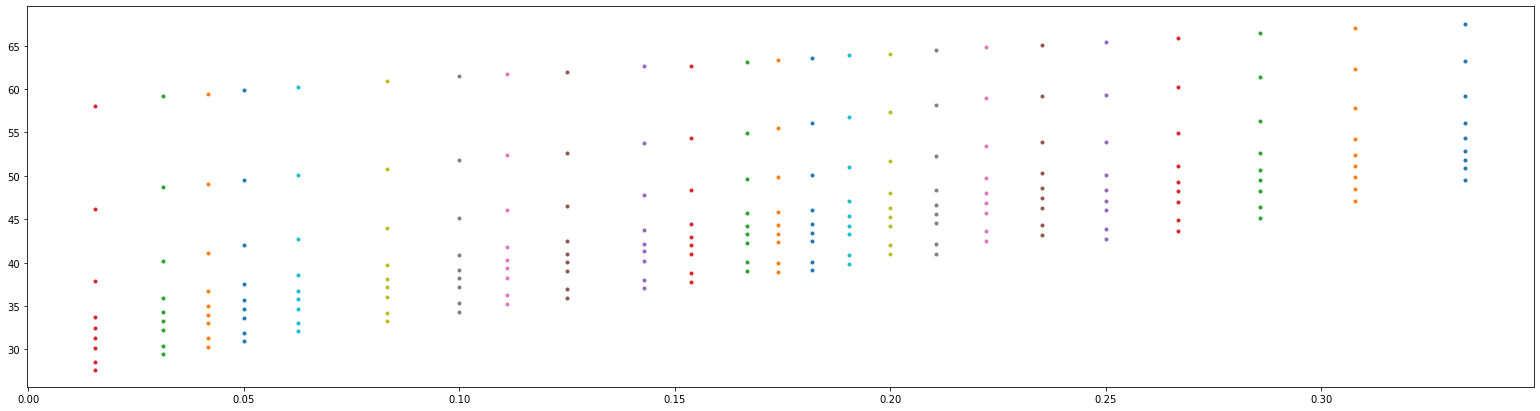

In [37]:
r_tmp =[
    [
        tscore_dict['MAE_true'][R_tmp][ind_tmp]
        for R_tmp
        in R_list
    ]
    for ind_tmp
    in range(len(tscore_dict['MAE_true'][9.0]))
]

a = np.linspace(0, 1, 11)
q = [
    np.quantile(i, a)[1:-1]
    for i
    in np.swapaxes(r_tmp, 0, 1)
]
np.shape(q)

fig, axs = plt.subplots(figsize = (27, 7))
[
    axs.plot(np.repeat(1/np.array(R_tmp), len(i)), i, '.')
    for i, R_tmp
    in zip(q, R_list)
];

# Final SPEED UP (oracle and not)

In [38]:
def final_speed_up(R_list, true, target, pred = None, geq = True, inf_quality_value = 50):
    
    if pred is None:
        pred = copy.deepcopy(true)
        
    R_list_sort = np.sort(R_list)[::-1]
    
    if geq == True:
        def compare(x, y):
            return x>=y
    else:
        def compare(x, y):
            return x<=y
    
    z = np.zeros(len(true[R_list[0]]))
    
    speed_up_vector = copy.deepcopy(z)
    metric_vector = copy.deepcopy(z)
    diff_vector = copy.deepcopy(z)
    
    
    for R_tmp in R_list_sort:
        true_tmp = true[R_tmp]
        pred_tmp = pred[R_tmp]
                
        condition = np.logical_and(compare(pred_tmp, target),
                                   speed_up_vector == 0,
                                  )
        speed_up_vector = np.where(condition,
                                   R_tmp,
                                   speed_up_vector,
                                  )
                
        metric_vector = np.where(condition,
                                 true_tmp,
                                 metric_vector,
                                )
        
        diff_vector = np.where(condition, 
                               true_tmp-pred_tmp,
                               diff_vector,
                              )
        
    speed_up_vector[speed_up_vector==0] = 1    
    metric_vector[metric_vector==0] = inf_quality_value
    diff_vector[diff_vector==0] = 0
    
    return (speed_up_vector, metric_vector, diff_vector)

In [39]:
def get_final_score(
        score_dict,
        R_list,
        thresh_list,
        data_type = ['_true', '_pred'],
        metric_type = ['MAE'],
        verbose = False,
        inf_quality_value = 50,
    ):
    
    speed_up_dict = {}
    metric_dict = {}
    diff_dict = {}

    for t_tmp in thresh_list:
        if verbose == True:
            print()
        for d, m in itertools.product(data_type, metric_type):

            true = score_dict[m+'_true']
            
            if d == '_true':
                pred = None
            else:
                pred = score_dict[m+'_pred']

            (speed_up, metric, diff) = final_speed_up(
                    R_list,
                    true,
                    t_tmp,
                    pred,
                    geq = True,
                    inf_quality_value = inf_quality_value,
                )

            speed_up_dict[m+d+'_T'+str(t_tmp)] = speed_up
            metric_dict[m+d+'_T'+str(t_tmp)] = metric
            diff_dict[m+d+'_T'+str(t_tmp)] = diff

            if verbose == True:
                print(m+d, t_tmp, np.round(np.mean(speed_up), 2), np.round(np.mean(metric), 2))

    return (speed_up_dict, metric_dict, diff_dict)

In [40]:
def extract_some_data_from_dict(dictionary, key):
    
    k_list_tmp = [k for k in list(speed_up_dict.keys()) if (key in k)]

    data = None
    for k_tmp in k_list_tmp:
        data_tmp = dictionary[k_tmp][np.newaxis]

        if data is None:
            data = data_tmp
        else:
            data = np.append(data, data_tmp, 0)
            
    return data

## merge train and validation together

In [41]:
score_dict = {}

keys = xscore_dict.keys()
for k in keys:
    score_dict[k] = {}
    for R_tmp in R_list:
        score_dict[k][R_tmp] = np.concatenate((xscore_dict[k][R_tmp], vscore_dict[k][R_tmp]), 0)

In [42]:
MAEdb_true = np.ravel(list((score_dict['MAE_true'].values())))
PSNR_true = np.ravel(list((score_dict['MSE_true'].values())))
SSIM_true = np.ravel(list((score_dict['SSIM_true'].values())))


thresh_MAEdb = np.arange(np.min(MAEdb_true), 50, 0.02)[1:]
# thresh_MAEdb = np.arange(30, 49, 0.01)[1:]

thresh_PSNR = np.arange(np.min(PSNR_true), 50, 0.02)[1:]

thresh_SSIM = np.arange(np.min(SSIM_true), 1, 0.002)[1:]

def remove_None(L):
    return [x for x in L if x is not None]

thresh_MAEdb_for_PSNR = np.array([np.max(MAEdb_true[PSNR_true<t]) for t in thresh_PSNR])
thresh_MAEdb_for_SSIM = np.array([np.max(MAEdb_true[SSIM_true<t]) for t in thresh_SSIM])
thresh_MAEdb_for_MAEdb = np.array([np.max(MAEdb_true[MAEdb_true<t]) for t in thresh_MAEdb])

In [43]:
def my_unique(thresh_MAEdb_for_, thresh):
    _, ind_unique = np.unique(thresh_MAEdb_for_, return_index = True)

    thresh_MAEdb_for_ = np.array(thresh_MAEdb_for_)[ind_unique]
    thresh = np.array(thresh)[ind_unique]
    
    return thresh_MAEdb_for_, thresh

# thresh_MAEdb_for_PSNR, thresh_PSNR = my_unique(thresh_MAEdb_for_PSNR, thresh_PSNR)
# thresh_MAEdb_for_SSIM, thresh_SSIM = my_unique(thresh_MAEdb_for_SSIM, thresh_SSIM)
# thresh_MAEdb_for_MAEdb, thresh_MAEdb = my_unique(thresh_MAEdb_for_MAEdb, thresh_MAEdb)

MSE
36.08168807983368
41.14168807983357
SSIM
0.9446072696291786
0.9786072696291787
MAE
47.99893859863234
49.9989385986323


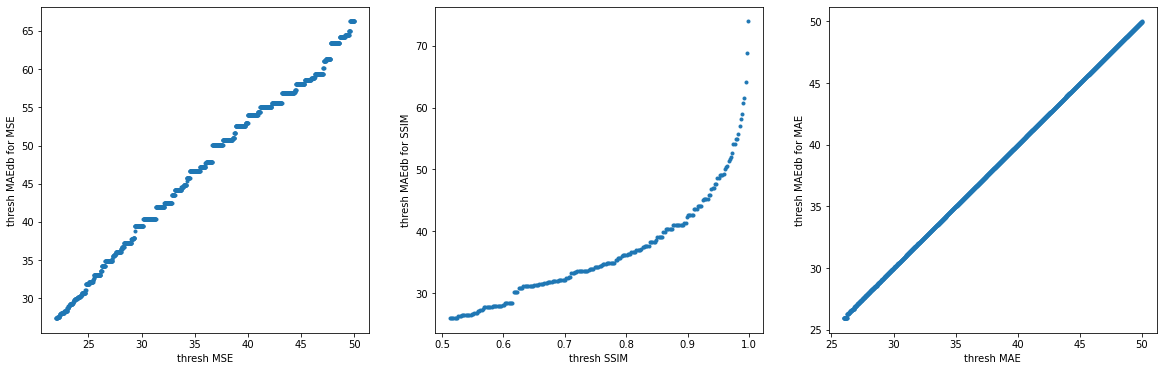

In [44]:
thresh_MAE_for_list = [thresh_MAEdb_for_PSNR, thresh_MAEdb_for_SSIM, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_PSNR, thresh_SSIM, thresh_MAEdb]
metric_type_list = ['MSE', 'SSIM', 'MAE']


fig, axs = plt.subplots(1, len(thresh_list))
fig.set_figwidth(20)
fig.set_figheight(6)


def find_nearest_arg(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

for ax, t_MAE, t, metric_type in zip(axs, thresh_MAE_for_list, thresh_list, metric_type_list):
    ax.plot(t, t_MAE, '.');
    ax.set(xlabel = 'thresh '+metric_type, ylabel = 'thresh MAEdb for '+metric_type)
    
    
    ind_tmp = find_nearest_arg(t_MAE, 48)
    print(metric_type)
    print(t[ind_tmp])
    
    ind_tmp = find_nearest_arg(t_MAE, 55)
    
    print(t[ind_tmp])
    

In [45]:
def expand_score_dictand_R_list(score_dict, R_list, metric_type_list = ['MAE', 'MSE', 'SSIM'], bias = False):
    
    if bias == True:
        bias_str = '_bias'
    else:
        bias_str = ''
    
    for metric_type in metric_type_list:
    
        len_tmp = len(score_dict[metric_type+'_true'][list(score_dict[metric_type+'_true'].keys())[0]])
    
        if metric_type == 'SSIM':
            R_1_performance = 1
        elif metric_type == 'MAE':
            R_1_performance = 60
            score_dict[metric_type+'_pred'+bias_str].update({1.0: np.ones(len_tmp)*R_1_performance})
        elif metric_type == 'MSE':
            R_1_performance = 60        

        score_dict[metric_type+'_true'].update({1.0: np.ones(len_tmp)*R_1_performance})

    R_list = [1.0] + R_list
    
    return score_dict, R_list

score_dict_expanded, R_list_expanded = expand_score_dictand_R_list(score_dict, R_list)

In [46]:
score_dict = tscore_dict
score_dict, R_list_expanded = expand_score_dictand_R_list(score_dict, R_list)

In [47]:
inf_quality_value = None
tfinal_score_MAEdb = {}
tfinal_score_MAEdb = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_MAEdb,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_MAEdb, tmetric_dict_MAEdb, tdiff_dict_MAEdb) = tfinal_score_MAEdb[1]

In [48]:
inf_quality_value = None
tfinal_score_PSNR = {}
tfinal_score_PSNR = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_PSNR,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_PSNR, tmetric_dict_PSNR, tdiff_dict_PSNR) = tfinal_score_PSNR[1]

In [49]:
inf_quality_value = None
tfinal_score_SSIM = {}
tfinal_score_SSIM = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_MAEdb_for_SSIM,
            data_type = ['_true', '_pred'],
            metric_type = ['MAE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_SSIM, tmetric_dict_SSIM, tdiff_dict_SSIM) = tfinal_score_SSIM[1]

In [50]:
inf_quality_value = None
tfinal_score_PSNR_oracle = {}
tfinal_score_PSNR_oracle = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_PSNR,
            data_type = ['_true'],
            metric_type = ['MSE'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_PSNR_oracle, tmetric_dict_PSNR_oracle, tdiff_dict_PSNR_oracle) = tfinal_score_PSNR_oracle[1]

inf_quality_value = None
tfinal_score_SSIM_oracle = {}
tfinal_score_SSIM_oracle = {
        v_sa_tmp: get_final_score(
            score_dict = score_dict,
            R_list = R_list_expanded,
            thresh_list = thresh_SSIM,
            data_type = ['_true'],
            metric_type = ['SSIM'],
            verbose = False,
            inf_quality_value = inf_quality_value,
        ) for v_sa_tmp in all_versions_sa
    }

(tspeed_up_dict_SSIM_oracle, tmetric_dict_SSIM_oracle, tdiff_dict_SSIM_oracle) = tfinal_score_SSIM_oracle[1]

In [51]:
metric_type_list = ['SSIM', 'MSE', 'MAE']
data_type_list = ['true', 'pred']

tspeed_up_dict_list = [tspeed_up_dict_SSIM, tspeed_up_dict_PSNR, tspeed_up_dict_MAEdb]
tspeed_up_dict_oracle_list = [tspeed_up_dict_SSIM_oracle, tspeed_up_dict_PSNR_oracle, tspeed_up_dict_MAEdb]

results_based_on_MAEdb = {}

thresh_MAEdb_list = [thresh_MAEdb_for_SSIM, thresh_MAEdb_for_PSNR, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_SSIM, thresh_PSNR, thresh_MAEdb]

for data_type in data_type_list:

    for tspeed_up_dict_tmp, tspeed_up_dict_oracle_tmp, metric_type, thresh_MAE_list_tmp, thresh_list_tmp in zip(tspeed_up_dict_list, tspeed_up_dict_oracle_list, metric_type_list, thresh_MAEdb_list, thresh_list):
        
        results_based_on_MAEdb['thresh_MAE_for_'+metric_type] = thresh_MAE_list_tmp
        results_based_on_MAEdb['thresh_'+metric_type] = thresh_list_tmp
        
        for t_MAE, t in zip(thresh_MAE_list_tmp, thresh_list_tmp):

            k_MAE_tmp = metric_type+'_'+data_type+'_TMAE'+str(t_MAE)
            k_tmp = metric_type+'_'+data_type+'_T'+str(t)
            
            tspeed_up_tmp = tspeed_up_dict_tmp['MAE_'+data_type+'_T'+str(t_MAE)]
            
            if data_type == 'true' and metric_type != 'MAE':
                tspeed_up_tmp = tspeed_up_dict_oracle_tmp[metric_type+'_'+data_type+'_T'+str(t)]
            
            results_based_on_MAEdb['speed_up_'+k_MAE_tmp] = tspeed_up_tmp
            results_based_on_MAEdb['speed_up_'+k_tmp] = tspeed_up_tmp
            
            results_based_on_MAEdb[k_MAE_tmp] = np.empty(len(tspeed_up_tmp))
            results_based_on_MAEdb[k_tmp] = np.empty(len(tspeed_up_tmp))

            for i, s in enumerate(tspeed_up_tmp):

                if s in R_list:
                    results_based_on_MAEdb[k_MAE_tmp][i] = tscore_dict[metric_type+'_true'][s][i]
                    results_based_on_MAEdb[k_tmp][i] = tscore_dict[metric_type+'_true'][s][i]
                elif metric_type == 'MSE' or metric_type == 'MAE':
                    results_based_on_MAEdb[k_MAE_tmp][i] = 60
                    results_based_on_MAEdb[k_tmp][i] = 60
                elif metric_type == 'SSIM':
                    results_based_on_MAEdb[k_MAE_tmp][i] = 1
                    results_based_on_MAEdb[k_tmp][i] = 1

## Re-define quality target

IXI-Cartesian




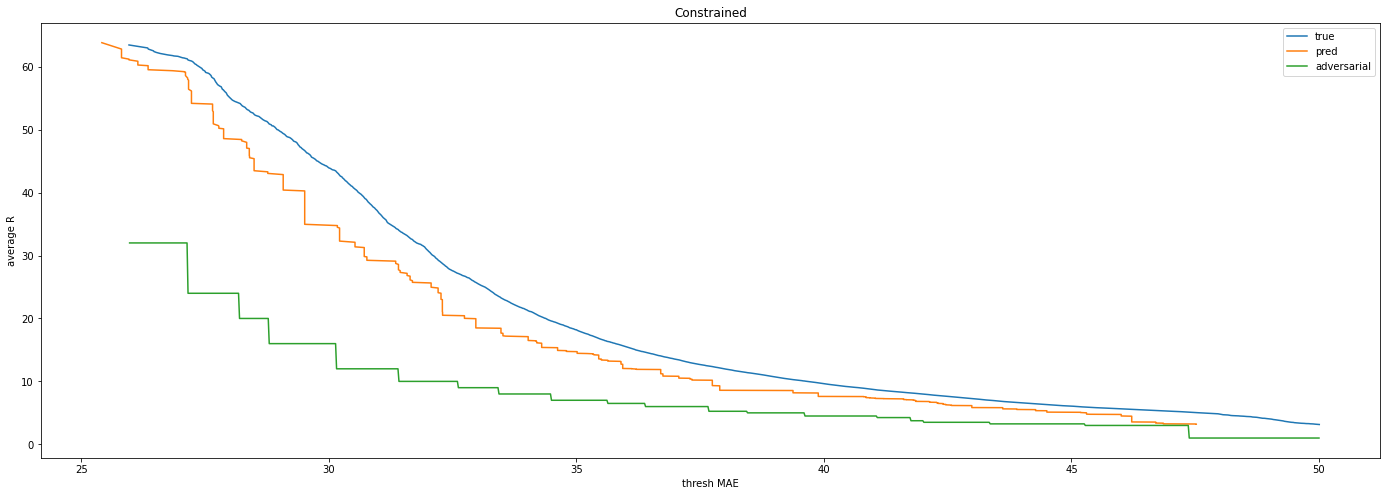

In [52]:
score_dict = tscore_dict

metric_type_list = ['MSE', 'SSIM', 'MAE']

metric_type_list = ['MAE']

ylim = [None, None]
xlim = (30, 47)

fig, axs = plt.subplots(1, len(metric_type_list), squeeze = False)
fig.set_figwidth(24)
fig.set_figheight(8)

axs = axs[0]

data_type_list = ['true', 'pred']

print(use_case)
print()
print()


plot_list = []
index = []
to_table = {}

for metric_type, ax in zip(metric_type_list, axs):
    
    x_plot = results_based_on_MAEdb['thresh_'+metric_type]
    
    for data_type in data_type_list:
        
        metric_min_list = np.array([np.min(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t_tmp)]) for t_tmp in x_plot])
        
        y_plot = [1/(np.mean(1/(results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t_tmp)]))) for t_tmp in x_plot]
        
        to_table[data_type] = [y_plot[np.argmin(np.abs(metric_min_list-i))] for i in np.arange(38, 47)]
        
        ax.plot(metric_min_list, y_plot, label = data_type)
        
        plot_list += [y_plot]
        index += ['y_'+data_type]
        
        plot_list += [metric_min_list]
        index += ['x_'+data_type]
        
        
        results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type] = metric_min_list
        
        for t_tmp, t_new in zip(x_plot, metric_min_list):
            results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(t_new)] = results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t_tmp)]
            results_based_on_MAEdb['speed_up'+'_'+metric_type+'_'+data_type+'_Tnew'+str(t_new)] = results_based_on_MAEdb['speed_up'+'_'+metric_type+'_'+data_type+'_T'+str(t_tmp)]
        
    R_adversarial = [
        R_list_expanded[::-1][np.argmax(
            [
                np.sum(score_dict[metric_type+'_true'][R_tmp]>t_tmp)
                for R_tmp in R_list_expanded[::-1]
            ]
        )]
        for t_tmp in x_plot
    ]
    
    to_table['adversarial'] = [R_adversarial[np.argmin(np.abs(x_plot-i))] for i in np.arange(38, 47)]
    to_table['index'] = np.arange(38, 47)
    ax.plot(x_plot, R_adversarial, label = 'adversarial')
    
    plot_list += [R_adversarial]
    index += ['y_adversarial']

    plot_list += [x_plot]
    index += ['x_adversarial']
    
    ax.legend()
    if metric_type == 'SSIM':
        xlim = (None, 1)
    else:
        xlim = (None, None)
    ax.set(title = 'Constrained', xlabel = 'thresh '+metric_type, ylabel = 'average R', xlim = xlim, ylim = ylim)

with open(os.path.join('results_paper', 'table_'+use_case+'.pkl'), 'wb') as f:
    pkl.dump(to_table, f)

f_name = f'R_vs_quality_target_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [53]:
threshold_MAEdb = 43
threshold_PSNR = 40
threshold_SSIM = 0.95

## Redefine threshold

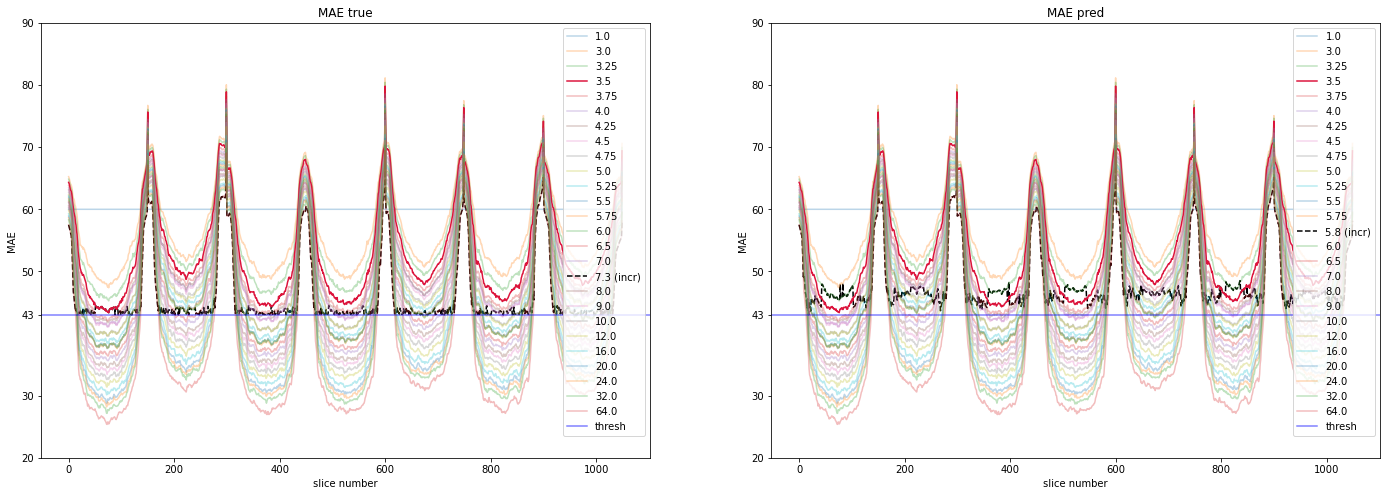

In [54]:
metric_type_list = ['MAE']

percentile = 0

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb, threshold_PSNR, threshold_SSIM]

fig, axss = plt.subplots(len(metric_type_list), len(data_type_list), squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(12*len(data_type_list))

for axs, metric_type, threshold in zip(axss, metric_type_list, threshold_list):
    
    thresh_MAE_for_tmp = results_based_on_MAEdb['thresh_MAE_for_'+metric_type]
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    
    t_MAE = thresh_MAE_for_tmp[np.argmin(np.abs(thresh_MAE_for_tmp-threshold))]
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    
    for ax, data_type in zip(axs, data_type_list):
        
        if data_type == 'pred':
            new_thresh_tmp = results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type]
            new_t = new_thresh_tmp[np.argmin(np.abs(new_thresh_tmp-t))]
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(new_t)]
            
        elif data_type == 'true':
            new_t = np.percentile(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)], percentile)
        
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]

        R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
        
                
        R_adversarial = R_list_expanded[::-1][np.argmax([
            np.sum(score_dict[metric_type+'_true'][R_tmp]>new_t)
            for R_tmp
            in R_list_expanded[::-1]
        ])]
        
        if data_type == 'pred':
            ax.plot(results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(new_t)],
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   ) 
            
        elif data_type == 'true':
            ax.plot(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)],
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   ) 
            
        
        def pick_alpha(R_adversarial, R_tmp, alpha = 0.3):
            if R_adversarial == R_tmp:
                return 1
            else:
                return alpha
            
        def pick_color(R_adversarial, R_tmp, color = 'crimson'):
            if R_adversarial == R_tmp:
                return color
            else:
                return ''
        
        [ax.plot(score_dict[metric_type+'_true'][R_tmp],
                 pick_color(R_adversarial, R_tmp),
                 alpha = pick_alpha(R_adversarial, R_tmp),
                 label = str(R_tmp),
                ) for R_tmp in R_list_expanded]
            
        ax.axhline(new_t,
                   color = 'b',
                   linestyle='-', 
                   alpha = 0.5,
                   label = f'thresh',
                  )
        
        handles, labels = ax.get_legend_handles_labels()
        
        order = np.argsort([R_incremental]+R_list_expanded+[1000])
                
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
        
        yticks = list(ax.get_yticks())
        
        yticks[np.argmin(np.abs(yticks-t))] = t
        
        ax.set(xlabel = 'slice number',
               ylabel = metric_type, 
               title = metric_type+' '+data_type,
               yticks = yticks,
              )
        
# fig.savefig(os.path.join('results_paper', f'Q_vs_slice_thresh_{np.round(threshold_MAEdb, 0)}_{use_case}.pdf'),bbox_inches='tight');

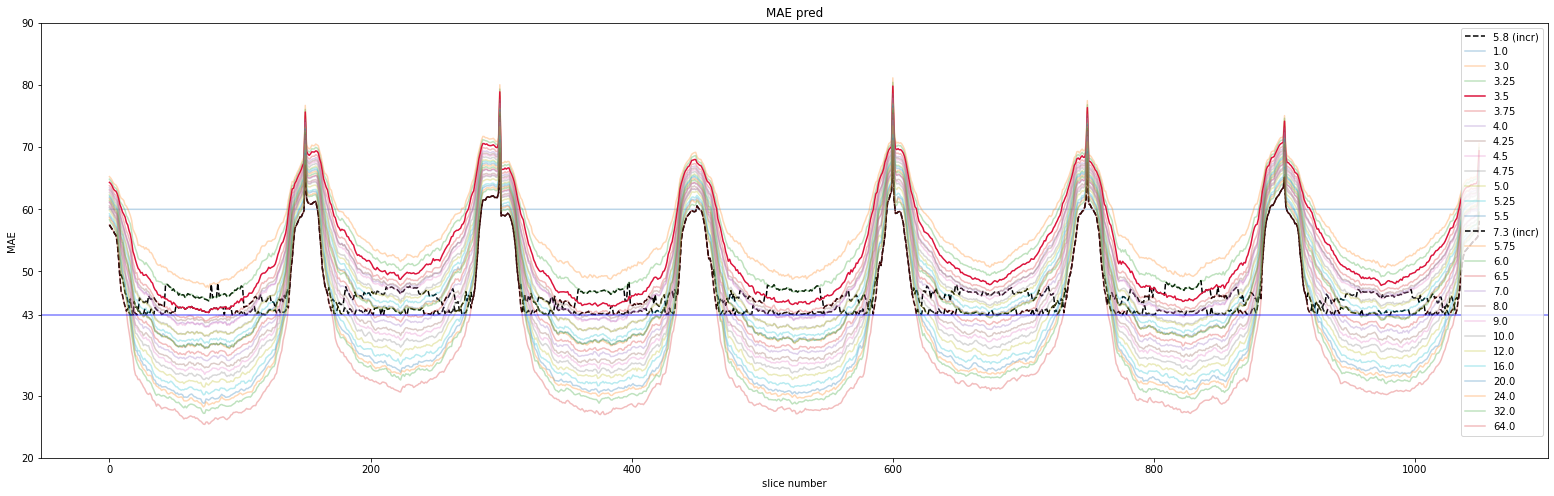

In [55]:
metric_type_list = ['MAE']

percentile = 0

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb]

fig, axss = plt.subplots(1, 1, squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(27)

plot_list = []
index_list = []

plot_list_short = []
index_list_short = []

plot_list_short_5_vols = []
index_list_short_5_vols = []

for axs, metric_type, threshold in zip(axss, metric_type_list, threshold_list):
    
    thresh_MAE_for_tmp = results_based_on_MAEdb['thresh_MAE_for_'+metric_type]
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    
    t_MAE = thresh_MAE_for_tmp[np.argmin(np.abs(thresh_MAE_for_tmp-threshold))]
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    
    for ax in axs:
    
        color_list = ['k--', 'b--']
    
        for data_type, color in zip(data_type_list, color_list):

            if data_type == 'pred':
                new_thresh_tmp = results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type]
                new_t = new_thresh_tmp[np.argmin(np.abs(new_thresh_tmp-t))]
                speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(new_t)]

            elif data_type == 'true':
                new_t = np.percentile(results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)], percentile)

                speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]

            R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)


            R_adversarial = R_list_expanded[::-1][np.argmax([
                np.sum(score_dict[metric_type+'_true'][R_tmp]>new_t)
                for R_tmp
                in R_list_expanded[::-1]
            ])]

            if data_type == 'pred':
                y_plot = results_based_on_MAEdb[metric_type+'_'+data_type+'_Tnew'+str(new_t)]

            elif data_type == 'true':
                y_plot = results_based_on_MAEdb[metric_type+'_'+data_type+'_T'+str(t)]
            
            ax.plot(y_plot,
                    'k--',
                    label = str(np.round(R_incremental, 1))+' (incr)',
                   )
            
            plot_list += [y_plot]
            index_list += ['y_'+data_type]
            
            plot_list_short += [y_plot[:450]]
            index_list_short += ['y_'+data_type]
            
            plot_list_short_5_vols += [y_plot[:750]]
            index_list_short_5_vols += ['y_'+data_type]

            def pick_alpha(R_adversarial, R_tmp, alpha = 0.3):
                if R_adversarial == R_tmp:
                    return 1
                else:
                    return alpha

            def pick_color(R_adversarial, R_tmp, color = 'crimson'):
                if R_adversarial == R_tmp:
                    return color
                else:
                    return ''

        [ax.plot(score_dict[metric_type+'_true'][R_tmp],
                 pick_color(R_adversarial, R_tmp),
                 alpha = pick_alpha(R_adversarial, R_tmp),
                 label = str(R_tmp),
                ) for R_tmp in R_list_expanded]

        for R_tmp in R_list_expanded:
            plot_list += [score_dict[metric_type+'_true'][R_tmp]]
            index_list += [str(R_tmp)]
            
            plot_list_short += [score_dict[metric_type+'_true'][R_tmp][:450]]
            index_list_short += [str(R_tmp)]
            
            plot_list_short_5_vols += [score_dict[metric_type+'_true'][R_tmp][:750]]
            index_list_short_5_vols += [str(R_tmp)]
            
        ax.axhline(new_t,
                   color = 'b',
                   linestyle='-', 
                   alpha = 0.5,
                   label = f'thresh',
                  )
        
        plot_list += [[threshold_MAEdb]*len(score_dict[metric_type+'_true'][R_tmp])]
        index_list += ['thresh']
        
        plot_list_short += [[threshold_MAEdb]*len(score_dict[metric_type+'_true'][R_tmp][:450])]
        index_list_short += ['thresh']
        
        plot_list_short_5_vols += [[threshold_MAEdb]*len(score_dict[metric_type+'_true'][R_tmp][:750])]
        index_list_short_5_vols += ['thresh']

        handles, labels = ax.get_legend_handles_labels()

        order = np.argsort([R_incremental]+R_list_expanded+[1000])

        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

        yticks = list(ax.get_yticks())

        yticks[np.argmin(np.abs(yticks-t))] = t

        ax.set(xlabel = 'slice number',
               ylabel = metric_type, 
               title = metric_type+' '+data_type,
               yticks = yticks,
              )
        
f_name = f'Q_vs_slice-target_{threshold_MAEdb}_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');
for plot_list_tmp, index_list_tmp, title_tmp in [[plot_list, index_list, ''], [plot_list_short, index_list_short, '_short'], [plot_list_short_5_vols, index_list_short_5_vols, '_short_5_vols']]:
    
    data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list_tmp[0])), data = np.array(plot_list_tmp).T, columns = index_list_tmp)
    index_name = 'index_name'
    data_for_csv.index.name = index_name
    data_for_csv = data_for_csv.reset_index()

    data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}{title_tmp}.csv'), sep='\t', index = False)

    fig.savefig(os.path.join('results_paper', f'Q_vs_slice_unified_thresh_{np.round(threshold_MAEdb, 0)}_{use_case}.pdf'),bbox_inches='tight');
    
dict_Q_tmp = dict(zip(index_list, plot_list))

In [56]:
threshold_MAEdb = threshold_MAEdb
threshold_PSNR = threshold_PSNR
threshold_SSIM = threshold_SSIM

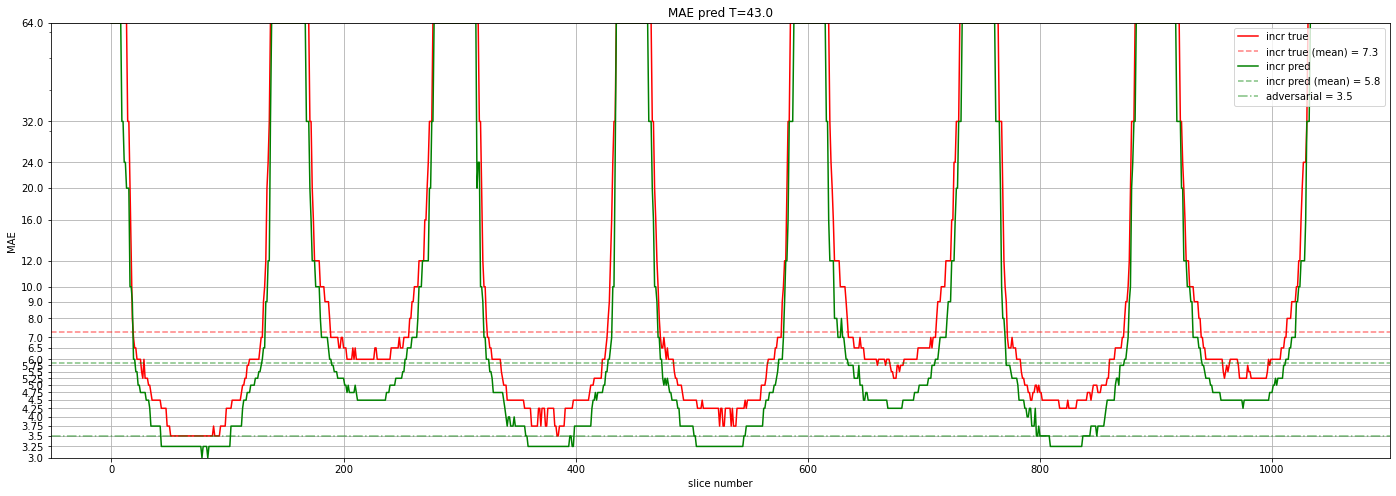

In [57]:
# metric_type_list = ['MAE', 'MSE', 'SSIM']
metric_type_list = ['MAE']

data_type_list = ['true', 'pred']

threshold_list = [threshold_MAEdb, threshold_PSNR, threshold_SSIM]

fig, axs = plt.subplots(len(metric_type_list), 1, squeeze = False)

fig.set_figheight(8*len(metric_type_list))
fig.set_figwidth(12*len(data_type_list))

plot_list = []
index_list = []

plot_list_short = []
index_list_short = []

plot_list_short_5_vols = []
index_list_short_5_vols = []

for ax, metric_type, threshold in zip(axs, metric_type_list, threshold_list):
    
    thresh_tmp = results_based_on_MAEdb['thresh_'+metric_type]
    thresh_new_tmp = np.array(results_based_on_MAEdb['thresh_new_'+metric_type+'_'+data_type])
    
    t = thresh_tmp[np.argmin(np.abs(thresh_tmp-threshold))]
    t_new = thresh_new_tmp[np.argmin(np.abs(thresh_new_tmp-threshold))]
    
    for data_type, color in zip(data_type_list, ['r', 'g']):
        
        if data_type == 'true':
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_T'+str(t)]
            
        elif data_type == 'pred':
            speed_up_tmp = results_based_on_MAEdb['speed_up_'+metric_type+'_'+data_type+'_Tnew'+str(t_new)]
        
        R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
        
        R_adversarial = R_list_expanded[::-1][np.argmax([
            np.sum(score_dict[metric_type+'_true'][R_tmp]>t)
            for R_tmp
            in R_list_expanded[::-1]
        ])]
        
        ax[0].plot(speed_up_tmp,
                color,
                label = 'incr '+data_type,
               )
        
        plot_list += [speed_up_tmp]
        index_list += [data_type]
        
        plot_list_short += [speed_up_tmp[:450]]
        index_list_short += [data_type]
        
        plot_list_short_5_vols += [speed_up_tmp[:750]]
        index_list_short_5_vols += [data_type]
            
        ax[0].axhline(R_incremental,
                   color = color,
                   linestyle='--', 
                   alpha = 0.5,
                   label = f'incr '+data_type+' (mean) = '+str(np.round(R_incremental, 1)),
                  )
        
        plot_list += [[R_incremental]*len(speed_up_tmp)]
        index_list += [data_type+'_mean']
        
        plot_list_short += [[R_incremental]*len(speed_up_tmp[:450])]
        index_list_short += [data_type+'_mean']
        
        plot_list_short_5_vols += [[R_incremental]*len(speed_up_tmp[:750])]
        index_list_short_5_vols += [data_type+'_mean']
        
    ax[0].axhline(R_adversarial,
               color = color,
               linestyle='-.', 
               alpha = 0.5,
               label = f'adversarial = '+str(np.round(R_adversarial, 1)),
              )
    plot_list += [[R_adversarial]*len(speed_up_tmp)]
    index_list += ['adversarial']
    
    plot_list_short += [[R_adversarial]*len(speed_up_tmp[:450])]
    index_list_short += ['adversarial']
    
    plot_list_short_5_vols += [[R_adversarial]*len(speed_up_tmp[:750])]
    index_list_short_5_vols += ['adversarial']

    ax[0].set()
    ax[0].legend()

    ax[0].set(xlabel = 'slice number',
              ylabel = metric_type, 
              title = metric_type+' '+data_type+' T='+str(np.round(t, 1)),
              yscale = 'log',
              yticks = R_list,
              yticklabels = R_list,
              ylim = (R_list[0], R_list[-1]),
          )
    ax[0].grid()

f_name = f'R_vs_slice-target_{threshold_MAEdb}_{use_case}'
    
# fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

for plot_list_tmp, index_list_tmp, title_tmp in [[plot_list, index_list, ''], [plot_list_short, index_list_short, '_short'], [plot_list_short_5_vols, index_list_short_5_vols, '_short_5_vols']]:
    
    data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list_tmp[0])), data = np.array(plot_list_tmp).T, columns = index_list_tmp)
    index_name = 'index_name'
    data_for_csv.index.name = index_name
    data_for_csv = data_for_csv.reset_index()

    data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}{title_tmp}.csv'), sep='\t', index = False)

    fig.savefig(os.path.join('results_paper', f'Q_vs_slice_unified_thresh_{np.round(threshold_MAEdb, 0)}_{use_case}.pdf'),bbox_inches='tight');
    
dict_R_tmp = dict(zip(index_list, plot_list))

In [58]:
np.shape(timage_dict[4.0][0])

(256, 256, 1)

In [59]:
# index_list_tmp = [5, 15 ,25, 35, ]

index_list_tmp = [30, 60, 90, 130]

# index_list_tmp = [20, 30, 60, 90, 120, 130, 180, 220, 260, 325, 340, 380, 420, 460, 500, 550]

# index_list_tmp = [50, 110]

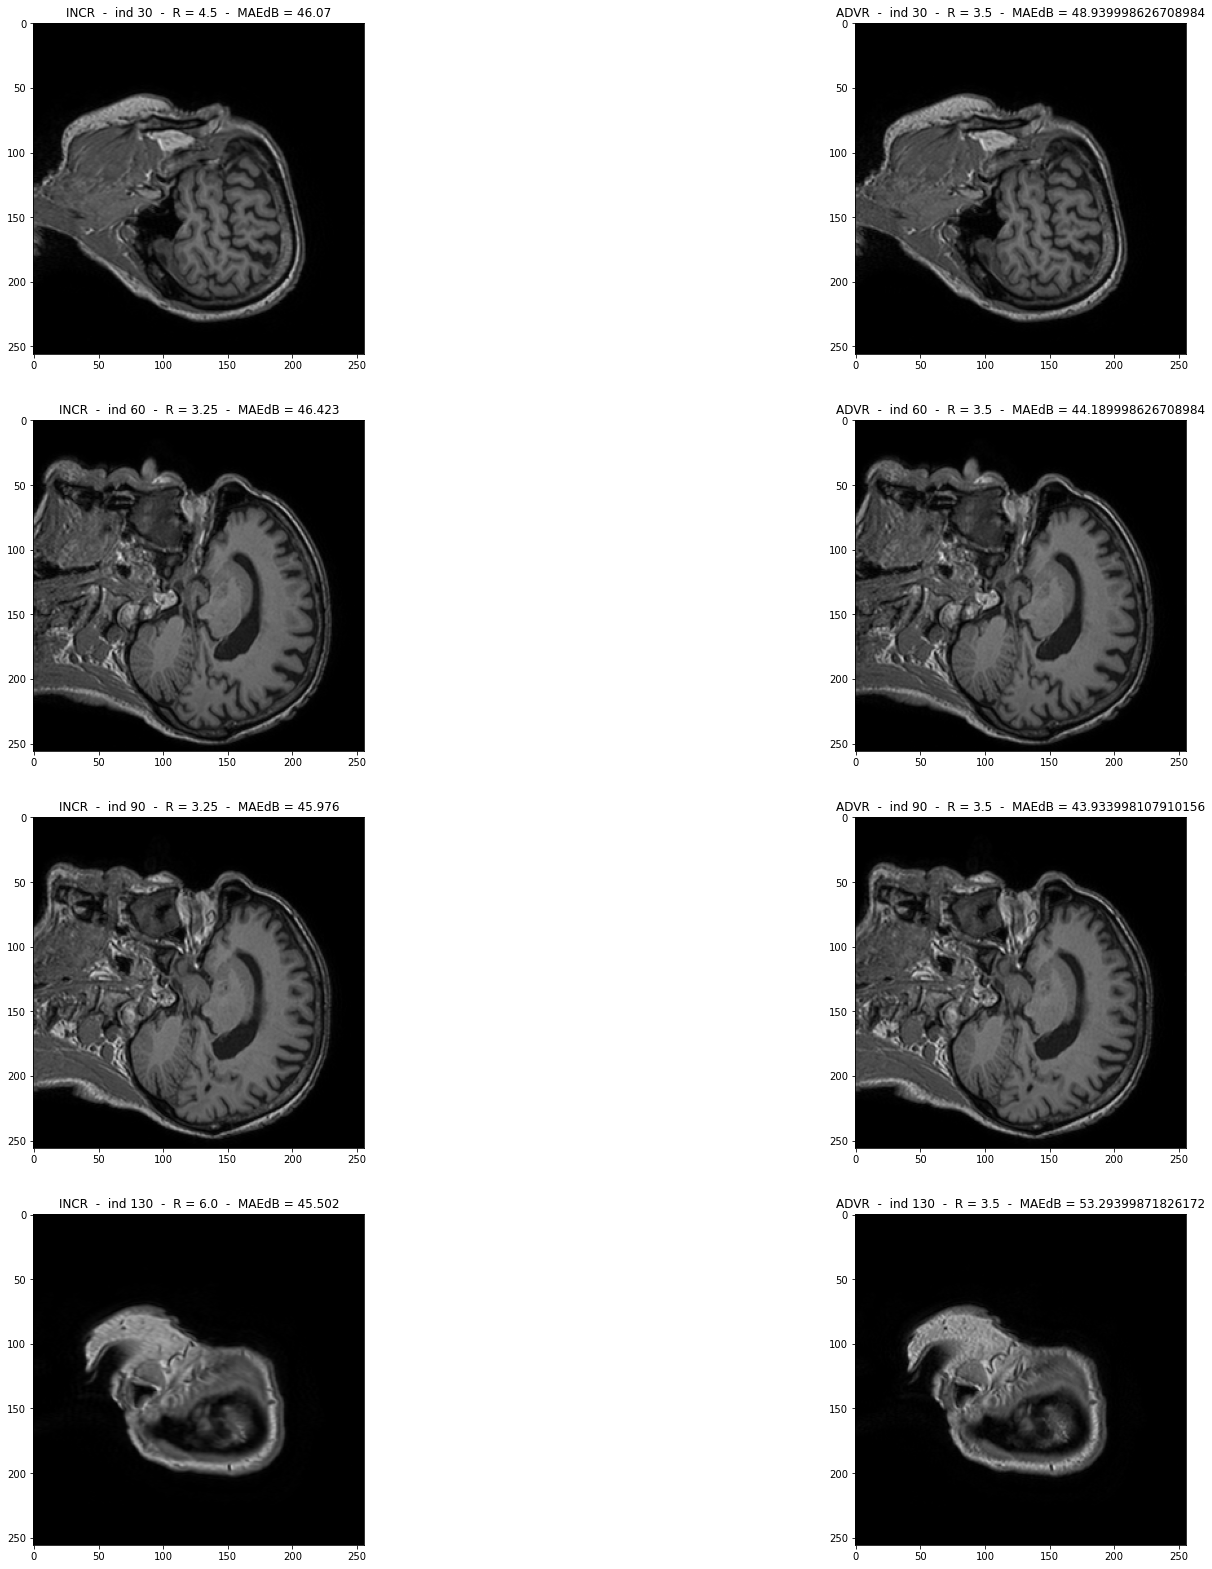

In [60]:
fig, axs = plt.subplots(len(index_list_tmp), 2, )
fig.set_figwidth(27)
fig.set_figheight(7*4)

R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    ax[0].imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    ax[0].set(title = f'INCR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')

R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    ax[1].imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    ax[1].set(title = f'ADVR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')
    

# path_tmp = os.path.join(
#         'results_paper',
#         'anatomical_volumes',
#         f'slice-ind_{ind}-R_{R}-{use_case}.pdf',
#     )

# plt.savefig(path_tmp, bbox_inches='tight', pad_inches = 0, transparent = True )


In [61]:
max_contrast = True

In [64]:
(_, _, tdata) = uty.load_dataset(dataset = 'IXI')

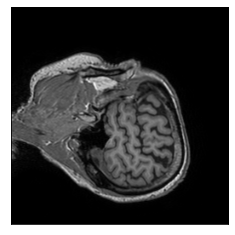

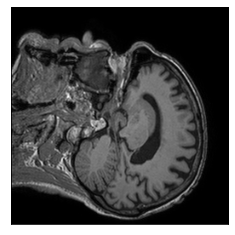

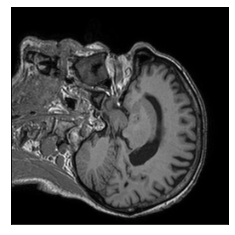

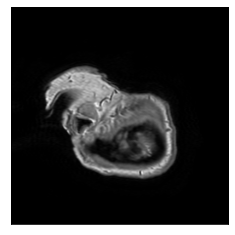

In [65]:
# fig, axs = plt.subplots(len(index_list_tmp), 2, )
# fig.set_figwidth(27)
# fig.set_figheight(7*4)

R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    # plt.imshow(timage_dict[R_tmp][ind_tmp, ..., 0], cmap = 'gray', vmin = 0, vmax = 1)
    # ax[0].set(title = f'INCR  -  ind {ind_tmp}  -  R = {R_tmp}  -  MAEdB = {np.round(Q_tmp, 3)}')
    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'more', 
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_reb.pdf',
        )

    # plt.axis('off')
    # plt.savefig(path_tmp, bbox_inches='tight', pad_inches = 0, transparent = True)

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    
    if max_contrast:
        im_tmp = im_tmp / np.max(tdata[ind_tmp, ..., 0])
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

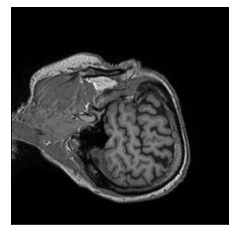

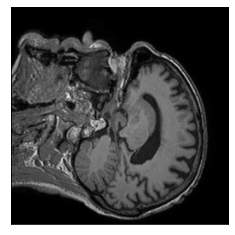

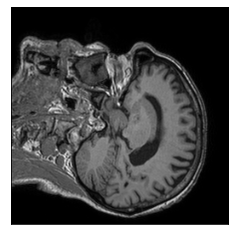

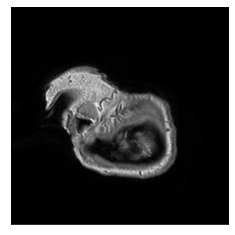

In [66]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal', 
            'more_recon_for_rev',
            'more', 
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_reb.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    
    if max_contrast:
        im_tmp = im_tmp / np.max(tdata[ind_tmp, ..., 0])
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

## Diff w.r.t. ground truth

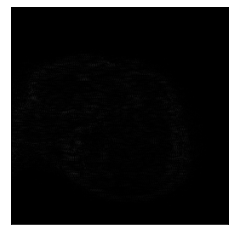

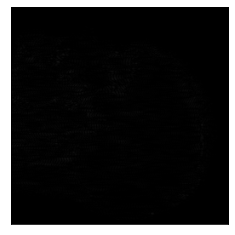

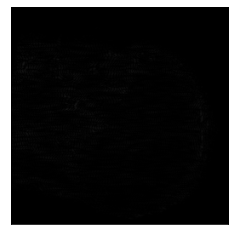

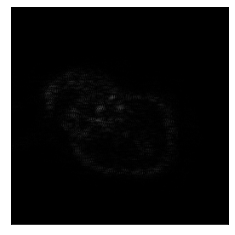

In [67]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

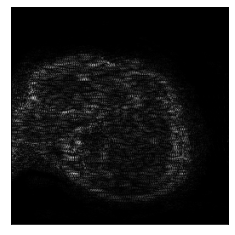

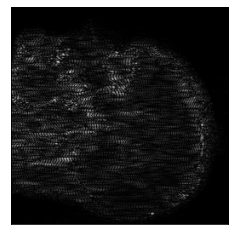

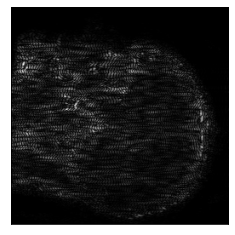

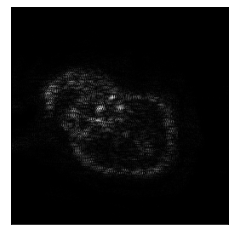

In [68]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
        im_tmp = np.abs(im_ref - im_tmp)
        
        im_tmp = im_tmp / np.max(im_tmp)
    
    
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

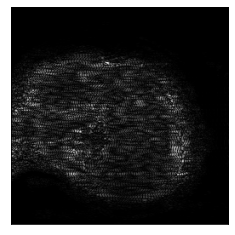

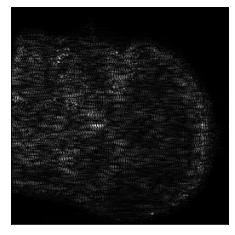

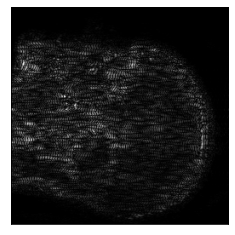

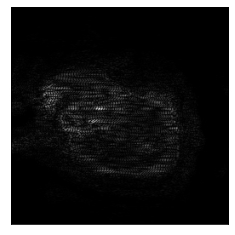

In [69]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    im_tmp = im_tmp / np.max(im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

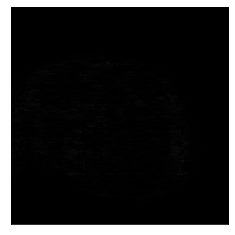

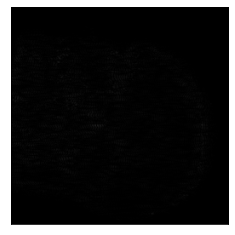

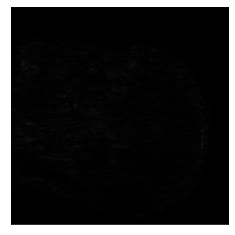

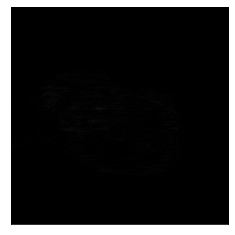

In [70]:
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        im_ref = im_ref / resc
        im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

## Diff with Improved Window Level and colorbar

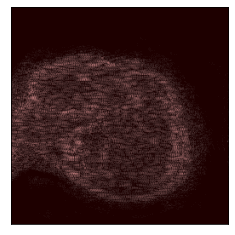

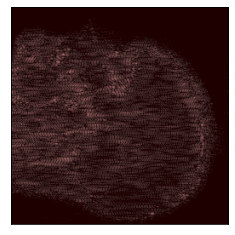

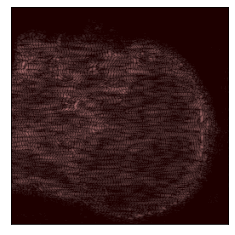

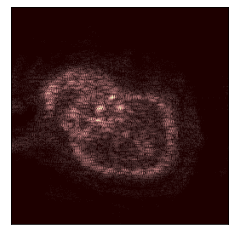

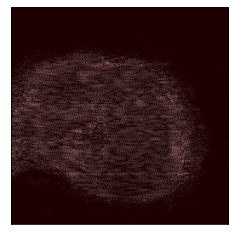

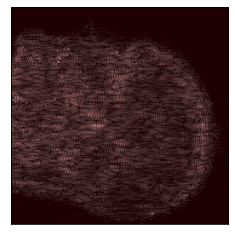

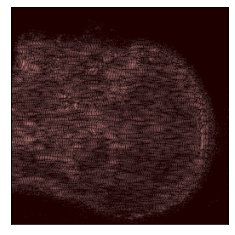

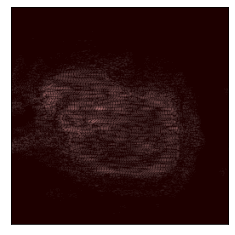

In [78]:
R_tmp_list = [dict_R_tmp['pred'][i] for i in index_list_tmp]
Q_tmp_list = [dict_Q_tmp['y_pred'][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp in zip(R_tmp_list, Q_tmp_list, index_list_tmp):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'win_lev_simple',
            f'slice-incr-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
#         im_ref = im_ref / resc
#         im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
        
    # im_tmp = im_tmp / np.max(im_tmp)
    
    
    
    imtmp = ax.imshow(im_tmp, cmap = 'pink', vmax=0.25)
    
    ax.set(xticks = [], yticks = [])
    
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # clbar = fig.colorbar(imtmp, cax=cax, orientation='vertical')
    
    # clbar.set_ticks([np.arange(0,  np.max(im_tmp), , )])
    # clbar.set_ticks(np.arange(0, np.max(im_tmp)))
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

###################################################################### CLASSIC
    
    
R_tmp_list = [R_adversarial]*len(index_list_tmp)
Q_tmp_list = [dict_Q_tmp[str(R_adversarial)][i] for i in index_list_tmp]
for R_tmp, Q_tmp, ind_tmp, ax in zip(R_tmp_list, Q_tmp_list, index_list_tmp, axs):

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            'more_recon_for_rev',
            'win_lev_simple',
            f'slice-classic-ind_{ind_tmp}-R_{R_tmp}-{use_case}-MAE_{np.round(Q_tmp, 1)}_diff_contrast.pdf',
        )

    fig, ax = plt.subplots()
    
    im_tmp = timage_dict[R_tmp][ind_tmp, ..., 0]
    im_ref = tdata[ind_tmp, ..., 0]
    
    if max_contrast:
        
        resc = np.max(im_ref)
        
        # im_ref = im_ref / resc
        # im_tmp = im_tmp / resc
    
    im_tmp = np.abs(im_ref - im_tmp)
    
    # im_tmp = im_tmp / np.max(im_tmp)
    
    imtmp = ax.imshow(im_tmp, cmap = 'pink', vmax=0.25)
    
    ax.set(xticks = [], yticks = [])
    
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(imtmp, cax=cax, orientation='vertical')
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()

In [ ]:
FINE

## New results presentation

In [ ]:
metric_type_list = ['SSIM', 'MSE', 'MAE']
data_type_list = ['true', 'pred']

tspeed_up_dict_list = [tspeed_up_dict_SSIM, tspeed_up_dict_PSNR, tspeed_up_dict_MAEdb]
tspeed_up_dict_oracle_list = [tspeed_up_dict_SSIM_oracle, tspeed_up_dict_PSNR_oracle, tspeed_up_dict_MAEdb]

results_based_on_MAEdb_2 = {}

thresh_MAEdb_list = [thresh_MAEdb_for_SSIM, thresh_MAEdb_for_PSNR, thresh_MAEdb_for_MAEdb]
thresh_list = [thresh_SSIM, thresh_PSNR, thresh_MAEdb]

for data_type in data_type_list:

    for tspeed_up_dict_tmp, tspeed_up_dict_oracle_tmp, metric_type, thresh_MAE_list_tmp, thresh_list_tmp in zip(tspeed_up_dict_list, tspeed_up_dict_oracle_list, metric_type_list, thresh_MAEdb_list, thresh_list):
        
        results_based_on_MAEdb_2['thresh_MAE_for_'+metric_type] = thresh_MAE_list_tmp
        results_based_on_MAEdb_2['thresh_'+metric_type] = thresh_list_tmp
        
        for t_MAE, t in zip(thresh_MAE_list_tmp, thresh_list_tmp):

            
            for metric_type_2 in ['MAE', 'MSE', 'SSIM']:
                
                k_MAE_tmp = metric_type+'_'+data_type+'_TMAE'+str(t_MAE)+'-show_'+metric_type_2
                k_tmp = metric_type+'_'+data_type+'_T'+str(t)+'-show_'+metric_type_2

                tspeed_up_tmp = tspeed_up_dict_tmp['MAE_'+data_type+'_T'+str(t_MAE)]

                if data_type == 'true' and metric_type != 'MAE':
                    tspeed_up_tmp = tspeed_up_dict_oracle_tmp[metric_type+'_'+data_type+'_T'+str(t)]

                results_based_on_MAEdb_2['speed_up_'+k_MAE_tmp] = tspeed_up_tmp
                results_based_on_MAEdb_2['speed_up_'+k_tmp] = tspeed_up_tmp   
            
                results_based_on_MAEdb_2[k_MAE_tmp] = np.empty(len(tspeed_up_tmp))
                results_based_on_MAEdb_2[k_tmp] = np.empty(len(tspeed_up_tmp))
            
                for i, s in enumerate(tspeed_up_tmp):

                    if s in R_list:
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = tscore_dict[metric_type_2+'_true'][s][i]
                        results_based_on_MAEdb_2[k_tmp][i] = tscore_dict[metric_type_2+'_true'][s][i]
                    elif metric_type_2 == 'MSE' or metric_type == 'MAE':
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = 60
                        results_based_on_MAEdb_2[k_tmp][i] = 60
                    elif metric_type_2 == 'SSIM':
                        results_based_on_MAEdb_2[k_MAE_tmp][i] = 1
                        results_based_on_MAEdb_2[k_tmp][i] = 1

In [ ]:
results_based_on_MAEdb_3 = {}

metric_type_list = ['MAE', 'MSE', 'SSIM']

    # t_list = results_based_on_MAEdb_2['thresh_MAE_for_'+metric_type]
t_list = results_based_on_MAEdb_2['thresh_MAE']        
    
for data_type in data_type_list:
    t_new_list = []
    for t_tmp in t_list:
        
        mae_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_MAE']
        t_new = np.min(mae_tmp)
        t_new_list += [t_new]
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_MAE'
        results_based_on_MAEdb_3[k_new] = mae_tmp

        mse_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_MSE']
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_MSE'
        results_based_on_MAEdb_3[k_new] = mse_tmp

        ssim_tmp = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_tmp)+'-show_SSIM']
        k_new = 'MAE_'+data_type+'_T'+str(t_new)+'-show_SSIM'
        results_based_on_MAEdb_3[k_new] = ssim_tmp
        
        
    results_based_on_MAEdb_3['thresh_MAE_'+data_type] = np.array(t_new_list)

In [ ]:
results_based_on_MAEdb_3;

In [ ]:
threshold_mae_list = [38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0]
R_tmp = 10.0

metric_type = 'MSE'

vline = True

metric_type_list = ['MSE', 'SSIM']
data_type_list = ['true', 'pred']

fig, axxs = plt.subplots(len(metric_type_list), 2)
fig.set_figwidth(20)
fig.set_figheight(7*len(metric_type_list))

print('\n\n\tcomparison of metric distribution -- classic MRI acquisition VS incremental MRI acquisition\n\n')

plot_list = []
index_list = []

for metric_type, axs in zip(metric_type_list, axxs):
    
    for data_type, ax in zip(data_type_list, axs):
        
        # ax.scatter(tscore_dict['MAE_true'][R_tmp], tscore_dict[metric_type+'_true'][R_tmp], label = f'classic -- R = {R_tmp}', zorder = 100) 
        
        for threshold_mae in threshold_mae_list:
            
            thresh_list_mae = results_based_on_MAEdb_3['thresh_MAE_'+data_type]
            t_mae = thresh_list_mae[np.argmin(np.abs(thresh_list_mae-threshold_mae))]
            mae = results_based_on_MAEdb_3['MAE_'+data_type+'_T'+str(t_mae)+'-show_MAE']
            mse = results_based_on_MAEdb_3['MAE_'+data_type+'_T'+str(t_mae)+'-show_'+metric_type]
            
            # speed_up_tmp = results_based_on_MAEdb['speed_up_MAE_'+data_type+'_T'+str(t_mae)]
            # R_incremental = 1/np.mean(np.ones(np.shape(speed_up_tmp))/speed_up_tmp)
            
            # scatter = ax.scatter(mae, mse, label = f'incremental -- thresh_MAEdb={threshold_mae} -- R = {np.round(R_incremental, 2)}')
            scatter = ax.scatter(mae, mse, label = f'incremental -- thresh_MAEdb={threshold_mae}')
            
            plot_list += [mse]
            index_list += ['y_'+data_type+'_'+metric_type+'_thresh_'+str(threshold_mae)]
            
            plot_list += [mae]
            index_list += ['x_'+data_type+'_'+metric_type+'_thresh_'+str(threshold_mae)] 
            
            color = scatter.get_facecolors()[0]
            
            ax.axvline(threshold_mae, color = color)
            
            ax.set(title = f'{data_type} -- {metric_type}', xlabel = 'MAE', ylabel = metric_type)
            
            ax.legend();
            
# fig.savefig(os.path.join('results_paper', f'MAE_thr_vs_metric_{use_case}.pdf'),bbox_inches='tight');

f_name = f'metric_vs_MAE-target_{use_case}'
    
fig.savefig(os.path.join('results_paper', f'{f_name}.pdf'),bbox_inches='tight');

data_for_csv = pd.DataFrame(index = np.arange(0, len(plot_list[0])), data = np.array(plot_list).T, columns = index_list)
index_name = 'index_name'
data_for_csv.index.name = index_name
data_for_csv = data_for_csv.reset_index()

data_for_csv.sort_values(by=index_name).to_csv(os.path.join('csv', f'{f_name}.csv'), sep='\t', index = False)

In [ ]:
len(thresh_MAEdb), len(thresh_PSNR), len(thresh_SSIM)

tscore_dict_expanded, R_list_expanded = expand_score_dictand_R_list(tscore_dict, R_list)

In [ ]:
threshold_mae_list = thresh_MAEdb

vline = True

percentile_list = [0, 80, 95]
color_list = ['red', 'blue']

metric_type_list = ['MSE', 'SSIM']
data_type_list = ['true', 'pred']
data_type_list = ['pred']

fig, axxs = plt.subplots(len(metric_type_list), 1)
fig.set_figwidth(20)
fig.set_figheight(7*len(metric_type_list))

print('\n\n\tcomparison of metric distribution -- classic MRI acquisition VS incremental MRI acquisition\n\n')

for metric_type, ax in zip(metric_type_list, axxs):
    
    for data_type, color in zip(data_type_list, color_list):

        metric_percentile = []
        metric_min = []
        
        for threshold_mae in threshold_mae_list:
            
            thresh_list_mae = results_based_on_MAEdb_2['thresh_MAE']
            t_mae = thresh_list_mae[np.argmin(np.abs(thresh_list_mae-threshold_mae))]
            metric = results_based_on_MAEdb_2['MAE_'+data_type+'_T'+str(t_mae)+'-show_'+metric_type]
            
            p_tmp = np.percentile(metric, percentile_list)
            
            metric_min += [np.min(metric)]
            metric_percentile += [p_tmp]
            
        # ax.plot(threshold_mae_list, np.array(metric_percentile), color = color, label = data_type)
        
        dash_list = ['-', '--', ':']
        
        [ax.plot(threshold_mae_list, m, d, color = color, label = data_type + ' - ' + str(p)) for m, d, p in zip(np.array(metric_percentile).T, dash_list, percentile_list)]
        
        if metric_type == 'SSIM':
            ylim = (0.6, 1.05)
        elif metric_type == 'MSE' or data_type == 'MAE':
            ylim = (20, 60)
        
    R_adversarial = [
        R_list_expanded[::-1][np.argmax(
            [
                np.sum(tscore_dict_expanded[metric_type+'_true'][R_tmp]>t_tmp)
                for R_tmp in R_list_expanded[::-1]
            ]
        )]
        for t_tmp in metric_min
    ]

    adversarial_percentile = [np.percentile(tscore_dict_expanded[metric_type+'_true'][R_tmp], percentile_list) for R_tmp in R_adversarial]
    
    [ax.plot(threshold_mae_list, m, d, color = 'k', label = 'adversarial' + ' - ' + str(p)) for m, d, p in zip(np.array(adversarial_percentile).T, dash_list, percentile_list)]
    
    # ax.plot(threshold_mae_list, , 'k--', label = 'adversarial')

    ax.set(title = f'{data_type} -- {metric_type} -- {percentile_list}', xlabel = 'threshold MAE', ylabel = metric_type, xlim = (27, 47), ylim = ylim)

    ax.legend();

In [ ]:
FINE

# To table

In [ ]:
use_case_list = ['FastMRI-Unconstrained', 'FastMRI-Cartesian', 'IXI-Unconstrained', 'IXI-Cartesian']
to_table_dict = {}
for use_case_tmp in use_case_list:
    with open(os.path.join('results_paper', 'table_'+use_case_tmp+'.pkl'), 'rb') as f:
        to_table_dict[use_case_tmp] = pkl.load(f)

In [ ]:
i = 1
for i in np.arange(0, 8):
    tmp_list = []
    for k, v in to_table_dict.items():
        tmp = [v['true'][i], v['pred'][i], v['adversarial'][i]]
        # print(tmp)
        tmp_list += [[str(np.round(i, 2)) for i in tmp]]
        index = v['index'][i]

    tmp_print = [i[0]+' / '+i[1]+' / '+i[2] for i in tmp_list]

    print(
        '\multicolumn{2}{|c|}{',index,'} &\n ',
        '\multicolumn{1}{c|}{',tmp_print[0],'} &\n ',
        '\multicolumn{1}{c|}{',tmp_print[1],'} &\n ',
        '\multicolumn{1}{c|}{',tmp_print[2],'} &\n ',
        '\multicolumn{1}{c|}{',tmp_print[3],'} \\\ \hline\n',
    )

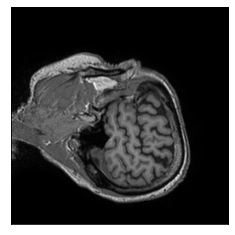

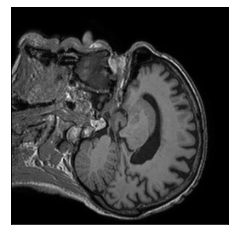

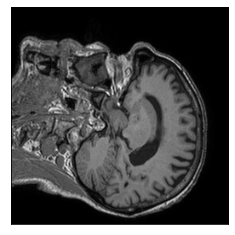

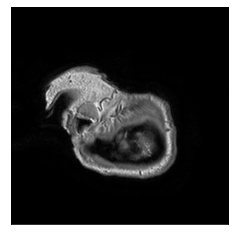

In [77]:
for ind_tmp in [30, 60, 90, 130]:

    path_tmp = os.path.join(
            'results_paper',
            'anatomical_volumes',
            'rebuttal',
            f'example-IXI-test_set_{ind_tmp}.pdf',
        )

    fig, ax = plt.subplots()

    im_tmp = tdata[ind_tmp, ..., 0]
    
    im_tmp = im_tmp / np.max(im_tmp)
    
    ax.imshow(im_tmp, cmap = 'gray', vmin = 0, vmax = 1)
    
    ax.set(xticks = [], yticks = [])
    
    fig.savefig(
        path_tmp,
        bbox_inches='tight',
        pad_inches = 0,
        transparent = True,
    )
    
    plt.show()
    

In [ ]:
plt.boxplot(

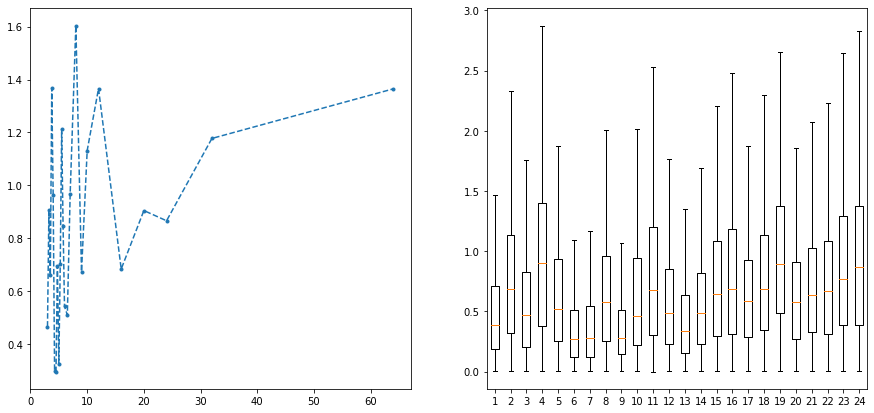

In [167]:
q_true = tscore_dict['MAE_true']
q_pred = tscore_dict['MAE_pred']

plot = []
box = np.empty((len(q_true.keys()), len(list(q_true.values())[0])))

for i, (kt, vt, kp, vp) in enumerate(zip(q_true.keys(), q_true.values(), q_pred.keys(), q_pred.values())):
    plot += [np.mean((vt-vp)**2)]
    # box[i] = (vt-vp)**2
    # box[i] = np.abs(vt-vp)
    box[i] = np.abs(vt - vp)
    
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(list(q_true.keys())[:-1], plot[:-1], '.--')
ax[1].boxplot(box[:-1].T, sym='');

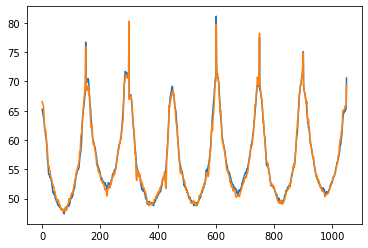

In [168]:
plt.plot(q_true[3.0])
plt.plot(q_pred[3.0])

In [143]:
q_true.keys()

dict_keys([3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.5, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0, 20.0, 24.0, 32.0, 64.0, 1.0])

In [169]:
with open(os.path.join('csv', 'box', f'boxplot-{use_case}.pkl'), 'wb') as f:
    dict_save = {
        'x': list(q_true.keys())[:-1],
        'y': box[:-1]}
    pkl.dump(dict_save, f)

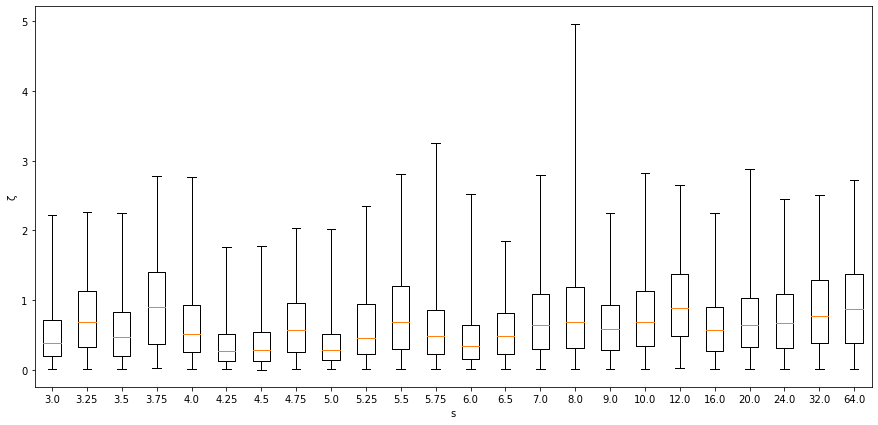

In [170]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.boxplot(box[:-1].T, sym='', positions=None, whis=(1, 99), labels=list(q_true.keys())[:-1]);
ax.set(xlabel='s', ylabel='ζ')
fig.savefig(os.path.join('results_paper', f'box-{use_case}.pdf'))